In [1]:
import os

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# 解壓縮資料

In [2]:
def unzip_data(path):
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('zip'):
                file_path = os.path.join(folder, file)
                print(file_path)

                sotre_path = os.path.join(folder, file.rsplit('.')[0])
                # 開啟 ZIP 壓縮檔 
                with zipfile.ZipFile(file_path, 'r') as zf:
                    # 解壓縮所有檔案至 /my/folder 目錄
                    zf.extractall(path=sotre_path)

In [3]:
# unzip_data('./swing')

In [4]:
def convert_csv(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=',')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=',')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=',')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=',')
    device_df = pd.read_csv(os.path.join(path, 'meta', 'device.csv'), delimiter=',')
    time_df = pd.read_csv(os.path.join(path, 'meta', 'time.csv'), delimiter=',')
    
    acc_df.to_csv(os.path.join(path, 'Accelerometer.csv'), index=False, sep=';')
    gyo_df.to_csv(os.path.join(path, 'Gyroscope.csv'), index=False, sep=';')
    linacc_df.to_csv(os.path.join(path, 'Linear Accelerometer.csv'), index=False, sep=';')
    mag_df.to_csv(os.path.join(path, 'Magnetometer.csv'), index=False, sep=';')
    device_df.to_csv(os.path.join(path, 'meta', 'device.csv'), index=False, sep=';')
    time_df.to_csv(os.path.join(path, 'meta', 'time.csv'), index=False, sep=';')

In [5]:
# convert_csv('./pocket/202301101952/target')
# convert_csv('./pocket/202301101952/source')

# 讀檔

In [6]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [7]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, chunk_size=5, seq_len=25):
#     length = datapoint_per_second * duration
    length = chunk_size * seq_len
    num_of_segs = int(np.floor(len(df) / length))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * length):int((i + 1) * length)].to_numpy()
        segments.append(np.array(np.split(seg, chunk_size)))
        
    return segments


def select_data(df):
#     return df[['acc_x', 'acc_y', 'acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]


def preprocess_data(df, chunk_size=5, seq_len=25):
    pre_df = select_data(df)
    segs = split_segments(pre_df, chunk_size, seq_len)
    
    return segs

In [8]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

        print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num):
    pair_data = []

    for folder in os.listdir(root_folder):
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(root_folder, folder)
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(folder_path)
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = align_data(source_df, target_df)
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        
#         print(source_df.system_time[0], target_df.system_time[0])
#         print(source_df.system_time[len(source_df) - 1], target_df.system_time[len(target_df) - 1])
#         print(len(source_df), len(target_df))
        
#         plt.figure(figsize=(30, 5))
#         plt.plot(np.arange(len(source_df)), source_df.acc_x)
#         plt.plot(np.arange(len(target_df)), target_df.acc_y)
#         plt.show()
        
        source_segs = preprocess_data(source_df, chunk_size, seq_len)
        target_segs = preprocess_data(target_df, chunk_size, seq_len)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [9]:
datapoint_per_second = 20
duration = 2
chunk_size = 7
seq_len = 21
classes = {'target': 0, 'front_pocket': 1, 'pocket': 2, 'swing': 3}

In [10]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [11]:
front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1)
pocket_pair_data = load_pair_data('./pocket', class_num=2)
swing_pair_data = load_pair_data('./swing', class_num=3)

./front_pocket/202302071628
./front_pocket/202302071628/source ./front_pocket/202302071628/target
./front_pocket/202302071652
./front_pocket/202302071652/source ./front_pocket/202302071652/target
./front_pocket/202302071523
./front_pocket/202302071523/source ./front_pocket/202302071523/target
./front_pocket/202302071531
./front_pocket/202302071531/source ./front_pocket/202302071531/target
./front_pocket/202302071715
./front_pocket/202302071715/source ./front_pocket/202302071715/target
./front_pocket/202302071641
./front_pocket/202302071641/source ./front_pocket/202302071641/target
./front_pocket/202302071541
./front_pocket/202302071541/source ./front_pocket/202302071541/target
./front_pocket/202302071619
./front_pocket/202302071619/source ./front_pocket/202302071619/target
./front_pocket/202302071704
./front_pocket/202302071704/source ./front_pocket/202302071704/target
./front_pocket/202302071724
./front_pocket/202302071724/source ./front_pocket/202302071724/target
./pocket/20230213210

In [12]:
print(len(front_pocket_pair_data), len(pocket_pair_data), len(swing_pair_data))

388 370 364


In [13]:
front_pocket_pair_data[0][0][0, -1], front_pocket_pair_data[0][2][0, -1]

(array([-1.46666997e+00,  3.02090550e-02,  1.02965024e+00, -4.78252917e-01,
        -3.82730037e-01,  1.22318631e-02,  8.28334045e+00, -1.33542404e+01,
         4.17045288e+01,  1.67575811e+09]),
 array([ 1.25826234e-01, -1.58992693e+00, -1.53935553e+00, -6.28472567e-02,
         3.16822752e-02,  2.58390278e-01, -3.71943283e+01,  1.32483292e+00,
        -2.49790649e+01,  1.67575811e+09]))

# 建立dataloader

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [15]:
# class ClassDataset(Dataset):
#     def __init__(self, data, label):
#         self.data = data
#         self.label = label

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.label[idx]

In [16]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [17]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [18]:
class Classifier(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.cnn = nn.Sequential(
            nn.Conv1d(9, 16, kernel_size=5),
            nn.LeakyReLU(),
            nn.Conv1d(16, 16, kernel_size=5),
            nn.LeakyReLU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16 * (seq_len - 8), hidden_size=64, num_layers=2, batch_first=True)
        
        self.last = nn.Sequential(
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
            nn.Softmax(dim=2),
        )
        
    def forward(self, x):  # input: (bs, chunk_size, seq_len, 9)
        h = torch.reshape(x, (len(x) * self.chunk_size, self.seq_len, -1))  # (bs, chunk_size, seq_len, 9) -> (bs * chunk_size, seq_len, 9)
        h = torch.permute(h, (0, 2, 1))  # (bs * chunk_size, seq_len, 9) -> (bs * chunk_size, 9, seq_len) [CNN要對最後一個維度做卷積]
        
        h = self.cnn(h)

        h = torch.permute(h, (0, 2, 1))
        h = torch.reshape(h, (len(x), self.chunk_size, -1))
        
        hz, _ = self.rnn(h)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.chunk_size, self.num_of_classes))
        
        return out, hz
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.fe_layer = nn.Sequential(
            nn.Linear(9, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )

        self.pos_encoder = PositionalEncoding(64 * self.seq_len, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
#         self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        
        self.fe_last = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 9),
        )
        
    def forward(self, source_data):
        
        ### step 1
        h_data = self.fe_layer(source_data)
        h_data = h_data.reshape((len(source_data), self.chunk_size, -1))
        
        ### step 2
        h_data = self.pos_encoder(h_data)
        z = self.encoder(h_data)
        
        ### step 3
        pred_data = z.reshape((len(source_data), self.chunk_size, self.seq_len, -1))
        pred_data = self.fe_last(pred_data)
        
        return pred_data
        

In [19]:
# class Discriminator(nn.Module):
#     def __init__(self, chunk_size=5, seq_len=21):
#         super(Discriminator, self).__init__()
        
#         self.chunk_size = chunk_size
#         self.seq_len = seq_len
        
#         self.feature_extractor = nn.Sequential(
#             nn.Linear(3, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 32),
#             nn.LeakyReLU(),
#         )
        
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
        
#         self.discriminant_layer = nn.Sequential(
#             nn.Linear(64 * self.seq_len, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, x):
#         h = self.feature_extractor(x)  # (bs, chunk_size, seq_len, 3) -> (bs, chunk_size, seq_len, 16)
        
#         h = h.reshape((len(x), self.chunk_size, -1))  # (bs, chunk_size, seq_len, 16) -> (bs, chunk_size, seq_len * 16)
#         hz, _ = self.lstm(h)  # (bs, chunk_size, seq_len * 16) -> (bs, chunk_size, seq_len * 16 * 2)
        
#         out = self.discriminant_layer(hz)
        
#         return out

In [20]:
def generator_loss(pred_data, target_data):
    lin_acc_loss = mse_loss(pred_data[:, :, :, 0:3], target_data[:, :, :, 0:3])
    gro_loss = mse_loss(pred_data[:, :, :, 3:6], target_data[:, :, :, 3:6])
    mag_loss = mse_loss(pred_data[:, :, :, 6:9], target_data[:, :, :, 6:9])

    total_loss = lin_acc_loss + gro_loss + mag_loss
    return total_loss, lin_acc_loss, gro_loss, mag_loss

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [21]:
front_pocket_half = int(len(front_pocket_pair_data) * 0.8)
pocket_half = int(len(pocket_pair_data) * 0.8)
swing_half = int(len(swing_pair_data) * 0.8)

train_data = front_pocket_pair_data[:front_pocket_half]  # swing_pair_data[:swing_half] +  + pocket_pair_data[:pocket_half]
valid_data = front_pocket_pair_data[front_pocket_half:]  # swing_pair_data[swing_half:] +  + pocket_pair_data[pocket_half:]

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=256)

In [22]:
batch = next(iter(train_loader))

In [23]:
# batch

In [24]:
EPOCH = 6000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()

In [25]:
model = NotSimpleTransformer(chunk_size=chunk_size, seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [26]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [27]:
def train(dataloader, draw=False):
    model.train()

    g_losses = []
    lin_acc_losses = []
    gro_losses = []
    mag_losses = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data[:, :, :, 0:9].to(device)
        target_data = target_data[:, :, :, 0:9].to(device)

        # generate mag
        predict_data = model(source_data)
        
        # generator loss
        gen_loss, lin_acc_loss, gro_loss, mag_loss = generator_loss(predict_data, target_data)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        lin_acc_losses.append(lin_acc_loss.item())
        gro_losses.append(gro_loss.item())
        mag_losses.append(mag_loss.item())
    
    if draw:
        rs = [predict_data[0, :, :, 6:9].detach().cpu().numpy(), target_data[0, :, :, 6:9].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(lin_acc_losses), np.mean(gro_losses), np.mean(mag_losses)

In [28]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    lin_acc_losses = []
    gro_losses = []
    mag_losses = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data[:, :, :, 0:9].to(device)
            target_data = target_data[:, :, :, 0:9].to(device)

            # generate mag
            predict_data = model(source_data)

            # generator loss
            gen_loss, lin_acc_loss, gro_loss, mag_loss = generator_loss(predict_data, target_data)

            # record loss
            g_losses.append(gen_loss.item())
            lin_acc_losses.append(lin_acc_loss.item())
            gro_losses.append(gro_loss.item())
            mag_losses.append(mag_loss.item())
    
    if draw:
        rs = [predict_data[0, :, :, 6:9].detach().cpu().numpy(), target_data[0, :, :, 6:9].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(lin_acc_losses), np.mean(gro_losses), np.mean(mag_losses)

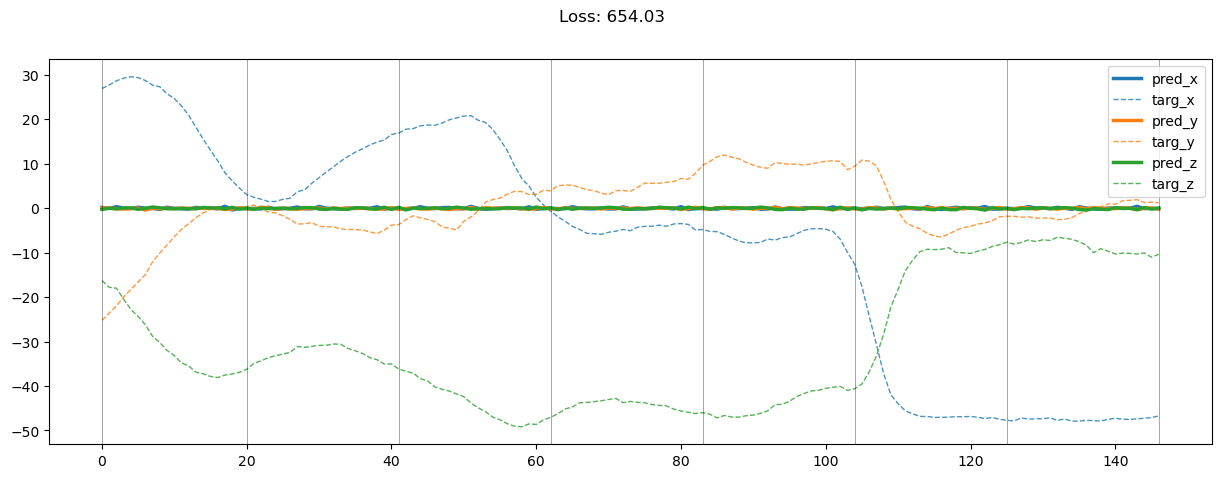

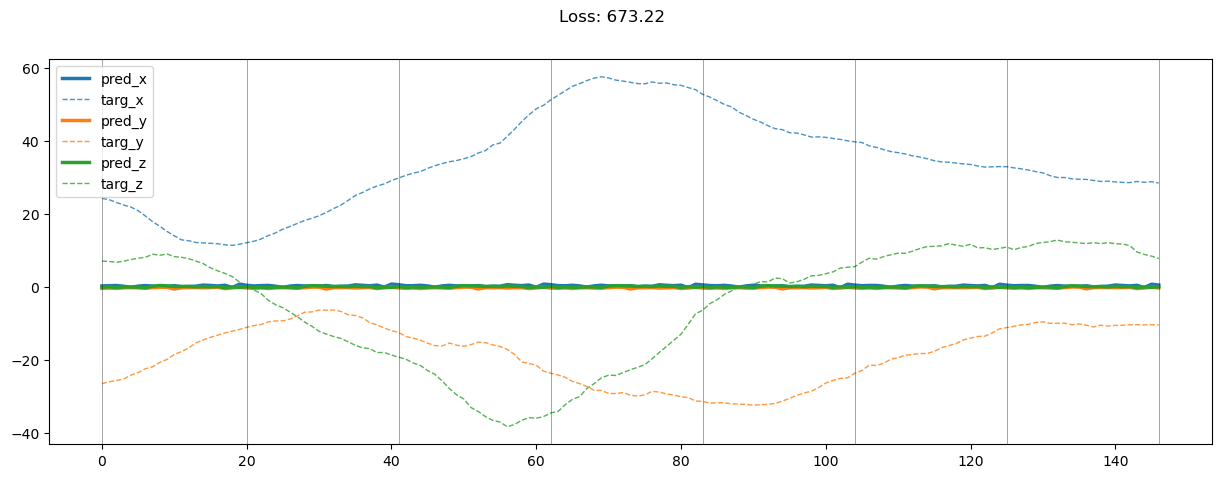

00019: train loss:  639.327, lin acc loss:  1.254, gro loss:  0.299, mag loss:  637.775
       valid loss:  652.704, lin acc loss:  1.028, gro loss:  0.295, mag loss:  651.381
00039: train loss:  648.979, lin acc loss:  1.195, gro loss:  0.316, mag loss:  647.467
       valid loss:  646.730, lin acc loss:  1.032, gro loss:  0.304, mag loss:  645.394
00059: train loss:  615.776, lin acc loss:  1.237, gro loss:  0.294, mag loss:  614.246
       valid loss:  641.596, lin acc loss:  1.028, gro loss:  0.287, mag loss:  640.281
00079: train loss:  608.706, lin acc loss:  1.207, gro loss:  0.279, mag loss:  607.219
       valid loss:  636.919, lin acc loss:  1.021, gro loss:  0.282, mag loss:  635.616
00099: train loss:  619.412, lin acc loss:  1.228, gro loss:  0.272, mag loss:  617.912
       valid loss:  631.769, lin acc loss:  1.021, gro loss:  0.259, mag loss:  630.489
00119: train loss:  619.471, lin acc loss:  1.156, gro loss:  0.243, mag loss:  618.073
       valid loss:  626.199, lin

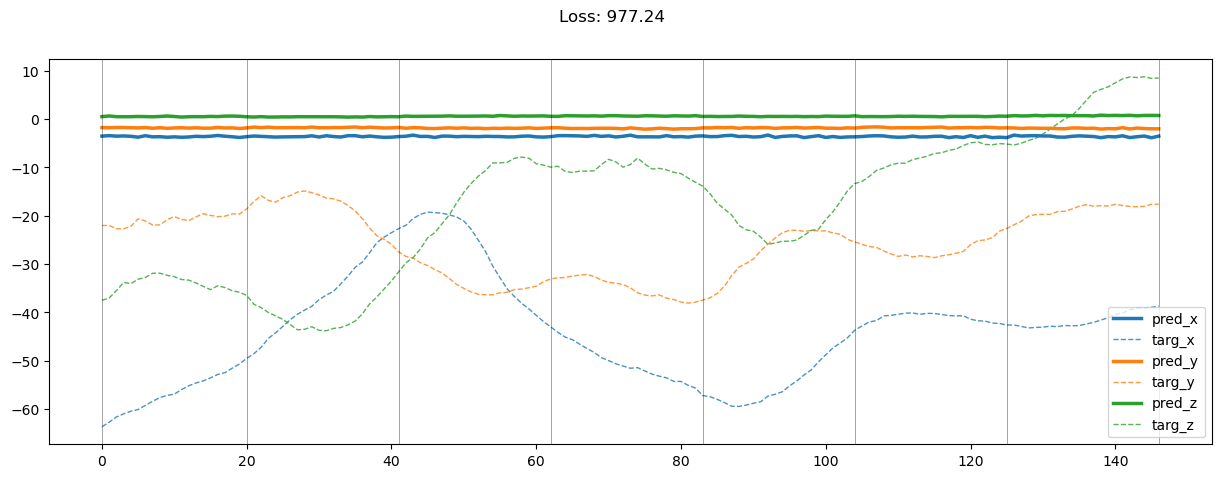

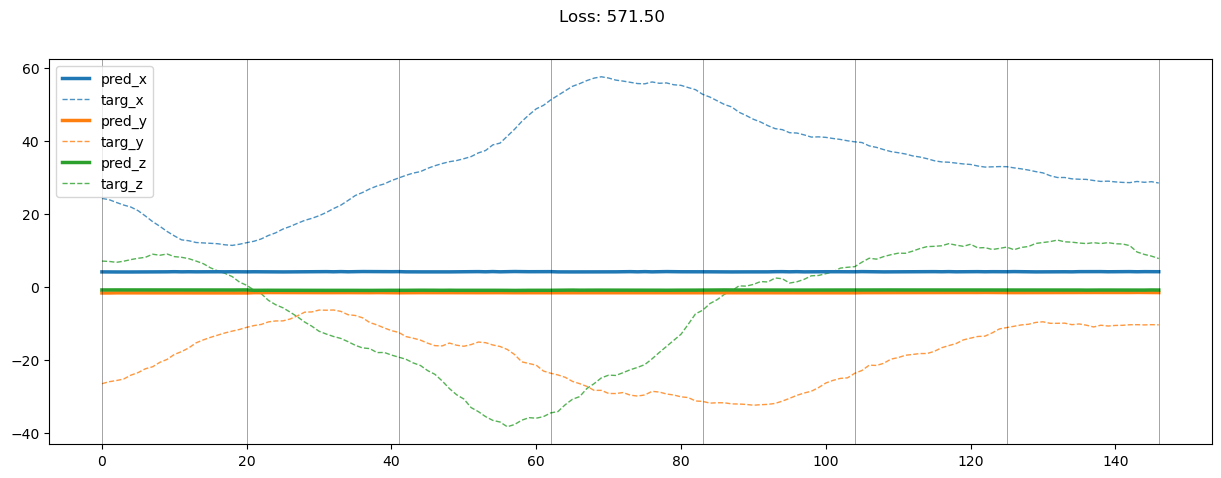

00199: train loss:  557.218, lin acc loss:  1.191, gro loss:  0.194, mag loss:  555.832
       valid loss:  597.914, lin acc loss:  1.022, gro loss:  0.180, mag loss:  596.712
00219: train loss:  579.123, lin acc loss:  1.204, gro loss:  0.181, mag loss:  577.738
       valid loss:  591.209, lin acc loss:  1.020, gro loss:  0.172, mag loss:  590.017
00239: train loss:  571.451, lin acc loss:  1.248, gro loss:  0.180, mag loss:  570.024
       valid loss:  582.777, lin acc loss:  1.012, gro loss:  0.165, mag loss:  581.600
00259: train loss:  560.840, lin acc loss:  1.194, gro loss:  0.168, mag loss:  559.478
       valid loss:  578.572, lin acc loss:  1.002, gro loss:  0.159, mag loss:  577.411
00279: train loss:  553.335, lin acc loss:  1.207, gro loss:  0.156, mag loss:  551.972
       valid loss:  566.229, lin acc loss:  0.990, gro loss:  0.154, mag loss:  565.084
00299: train loss:  534.724, lin acc loss:  1.160, gro loss:  0.158, mag loss:  533.406
       valid loss:  559.506, lin

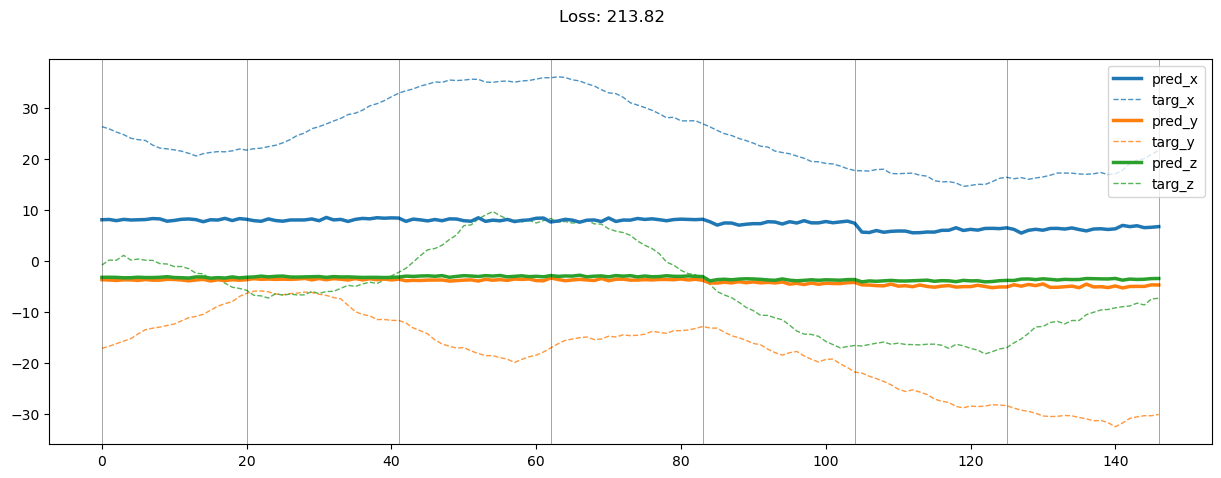

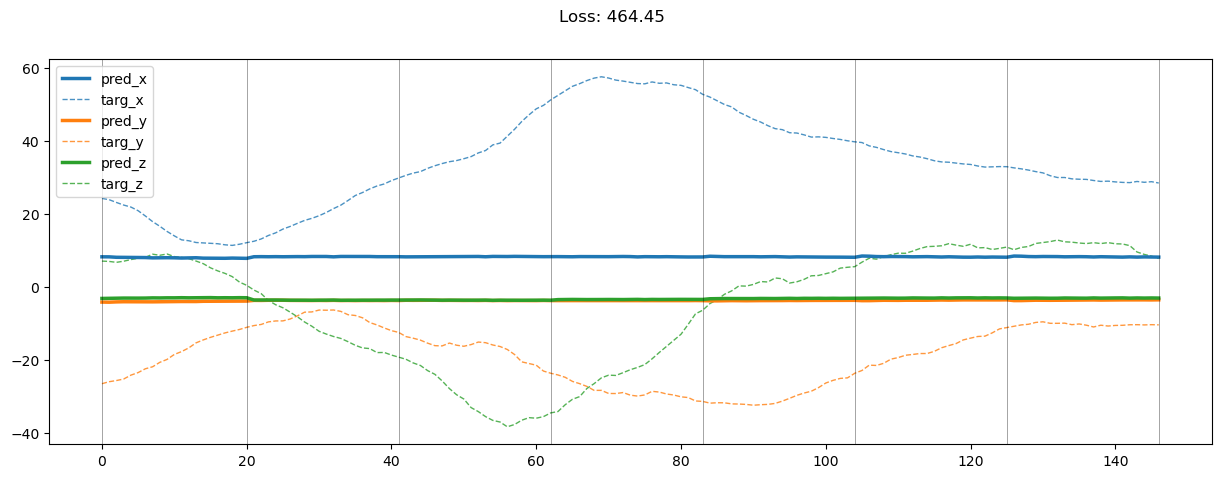

00399: train loss:  489.621, lin acc loss:  1.181, gro loss:  0.148, mag loss:  488.291
       valid loss:  505.588, lin acc loss:  0.929, gro loss:  0.141, mag loss:  504.518
00419: train loss:  472.251, lin acc loss:  1.077, gro loss:  0.141, mag loss:  471.032
       valid loss:  494.946, lin acc loss:  0.925, gro loss:  0.141, mag loss:  493.879
00439: train loss:  461.487, lin acc loss:  1.141, gro loss:  0.152, mag loss:  460.193
       valid loss:  483.491, lin acc loss:  0.923, gro loss:  0.141, mag loss:  482.427
00459: train loss:  451.553, lin acc loss:  1.153, gro loss:  0.153, mag loss:  450.247
       valid loss:  471.644, lin acc loss:  0.923, gro loss:  0.140, mag loss:  470.582
00479: train loss:  437.187, lin acc loss:  1.165, gro loss:  0.154, mag loss:  435.868
       valid loss:  460.407, lin acc loss:  0.922, gro loss:  0.140, mag loss:  459.345
00499: train loss:  432.246, lin acc loss:  1.096, gro loss:  0.144, mag loss:  431.006
       valid loss:  450.561, lin

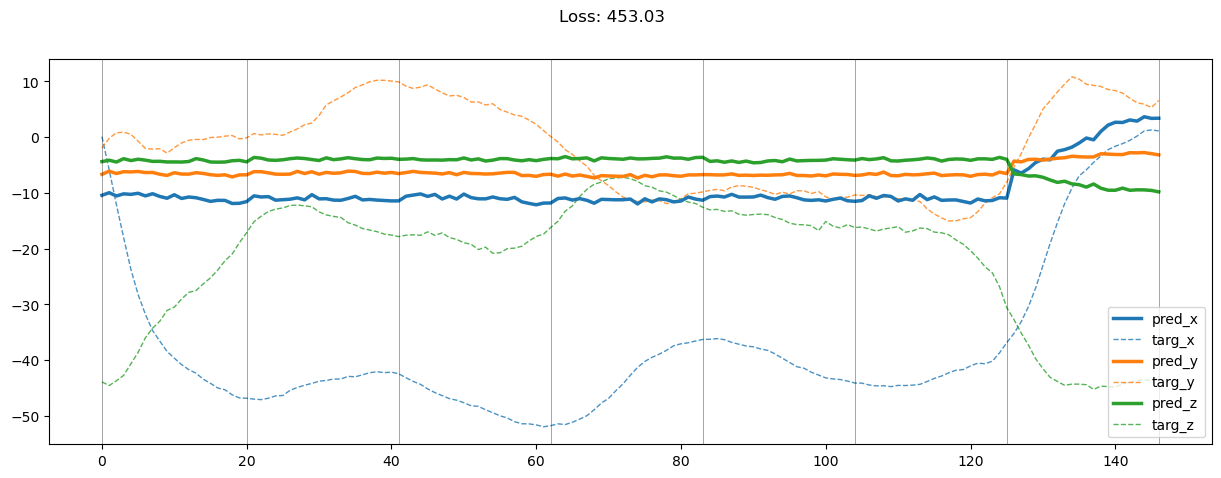

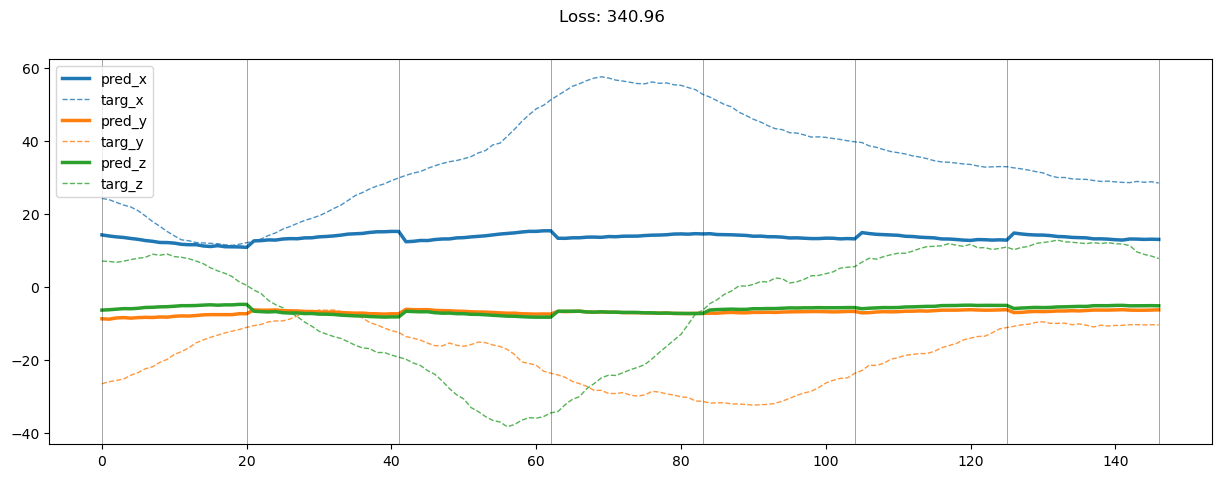

00599: train loss:  363.063, lin acc loss:  1.131, gro loss:  0.156, mag loss:  361.777
       valid loss:  400.074, lin acc loss:  0.920, gro loss:  0.140, mag loss:  399.014
00619: train loss:  358.505, lin acc loss:  1.088, gro loss:  0.144, mag loss:  357.273
       valid loss:  381.383, lin acc loss:  0.920, gro loss:  0.141, mag loss:  380.323
00639: train loss:  356.242, lin acc loss:  1.049, gro loss:  0.144, mag loss:  355.049
       valid loss:  369.515, lin acc loss:  0.921, gro loss:  0.141, mag loss:  368.453
00659: train loss:  348.190, lin acc loss:  1.075, gro loss:  0.140, mag loss:  346.974
       valid loss:  360.275, lin acc loss:  0.921, gro loss:  0.141, mag loss:  359.213
00679: train loss:  326.582, lin acc loss:  1.119, gro loss:  0.144, mag loss:  325.318
       valid loss:  348.928, lin acc loss:  0.921, gro loss:  0.141, mag loss:  347.865
00699: train loss:  323.536, lin acc loss:  1.083, gro loss:  0.144, mag loss:  322.309
       valid loss:  339.201, lin

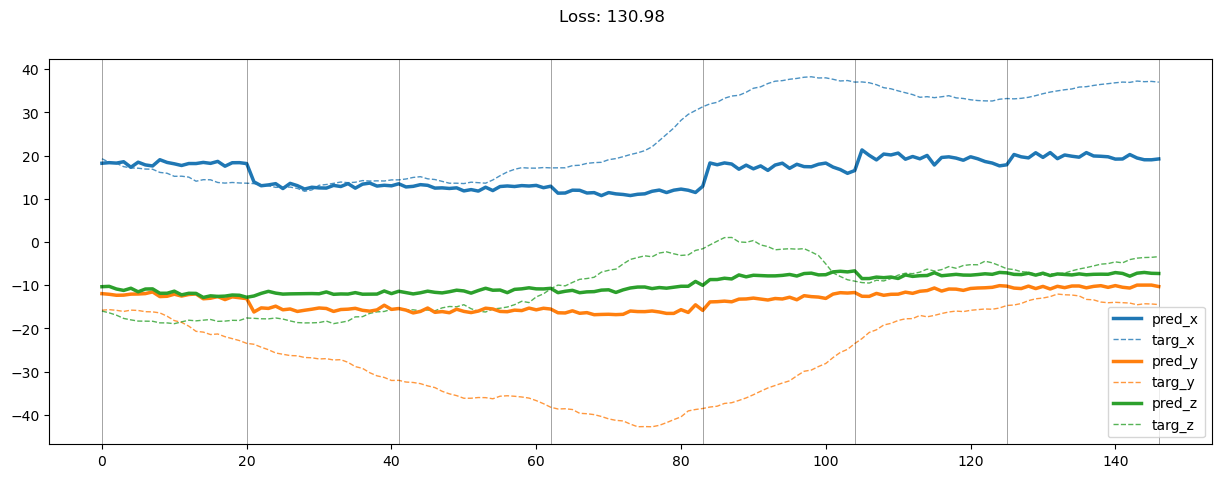

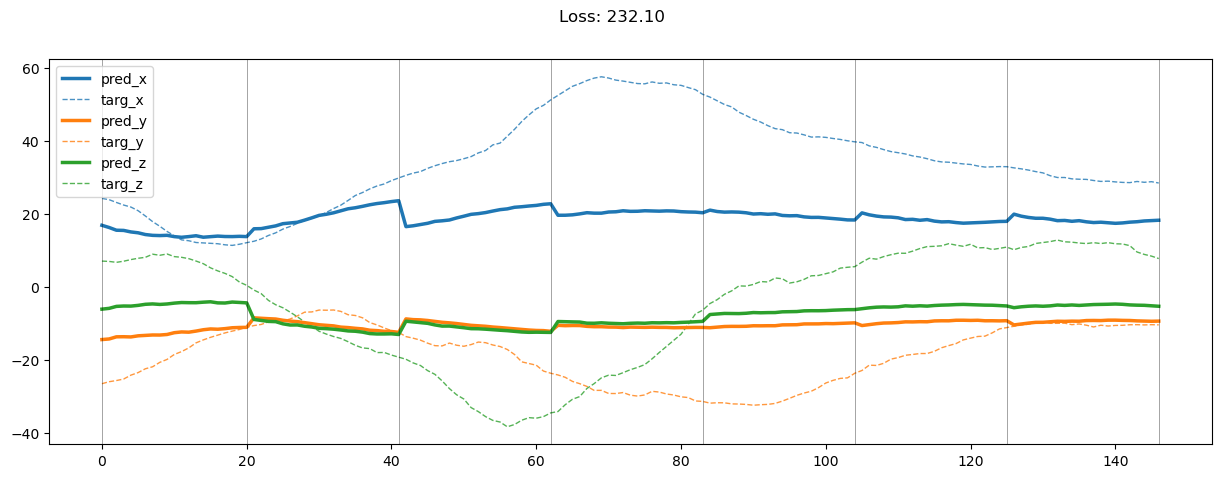

00799: train loss:  277.475, lin acc loss:  1.134, gro loss:  0.155, mag loss:  276.186
       valid loss:  286.195, lin acc loss:  0.919, gro loss:  0.141, mag loss:  285.135
00819: train loss:  259.828, lin acc loss:  1.087, gro loss:  0.151, mag loss:  258.590
       valid loss:  277.510, lin acc loss:  0.919, gro loss:  0.141, mag loss:  276.451
00839: train loss:  257.610, lin acc loss:  1.102, gro loss:  0.150, mag loss:  256.358
       valid loss:  268.889, lin acc loss:  0.919, gro loss:  0.141, mag loss:  267.829
00859: train loss:  244.798, lin acc loss:  1.126, gro loss:  0.148, mag loss:  243.525
       valid loss:  261.110, lin acc loss:  0.918, gro loss:  0.141, mag loss:  260.050
00879: train loss:  231.041, lin acc loss:  1.139, gro loss:  0.156, mag loss:  229.747
       valid loss:  250.915, lin acc loss:  0.918, gro loss:  0.141, mag loss:  249.856
00899: train loss:  227.104, lin acc loss:  1.118, gro loss:  0.150, mag loss:  225.837
       valid loss:  242.717, lin

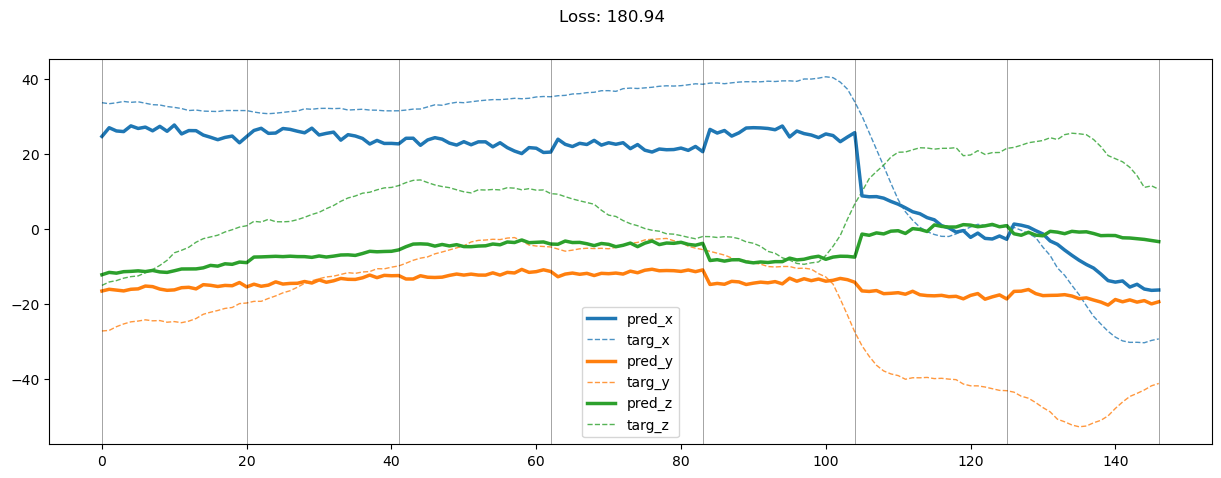

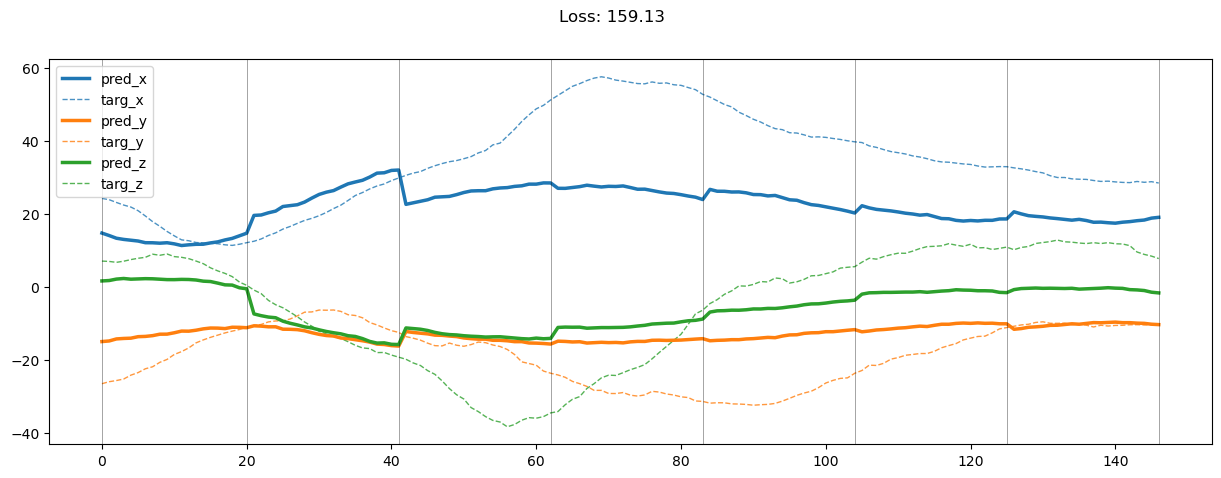

00999: train loss:  199.729, lin acc loss:  1.118, gro loss:  0.163, mag loss:  198.448
       valid loss:  217.229, lin acc loss:  0.916, gro loss:  0.142, mag loss:  216.170
01019: train loss:  182.563, lin acc loss:  1.114, gro loss:  0.145, mag loss:  181.303
       valid loss:  212.917, lin acc loss:  0.915, gro loss:  0.142, mag loss:  211.861
01039: train loss:  172.966, lin acc loss:  1.104, gro loss:  0.148, mag loss:  171.714
       valid loss:  206.977, lin acc loss:  0.915, gro loss:  0.142, mag loss:  205.920
01059: train loss:  184.352, lin acc loss:  1.109, gro loss:  0.161, mag loss:  183.082
       valid loss:  199.928, lin acc loss:  0.915, gro loss:  0.141, mag loss:  198.872
01079: train loss:  167.286, lin acc loss:  1.107, gro loss:  0.147, mag loss:  166.032
       valid loss:  238.298, lin acc loss:  0.914, gro loss:  0.143, mag loss:  237.241
01099: train loss:  155.747, lin acc loss:  1.099, gro loss:  0.140, mag loss:  154.508
       valid loss:  195.863, lin

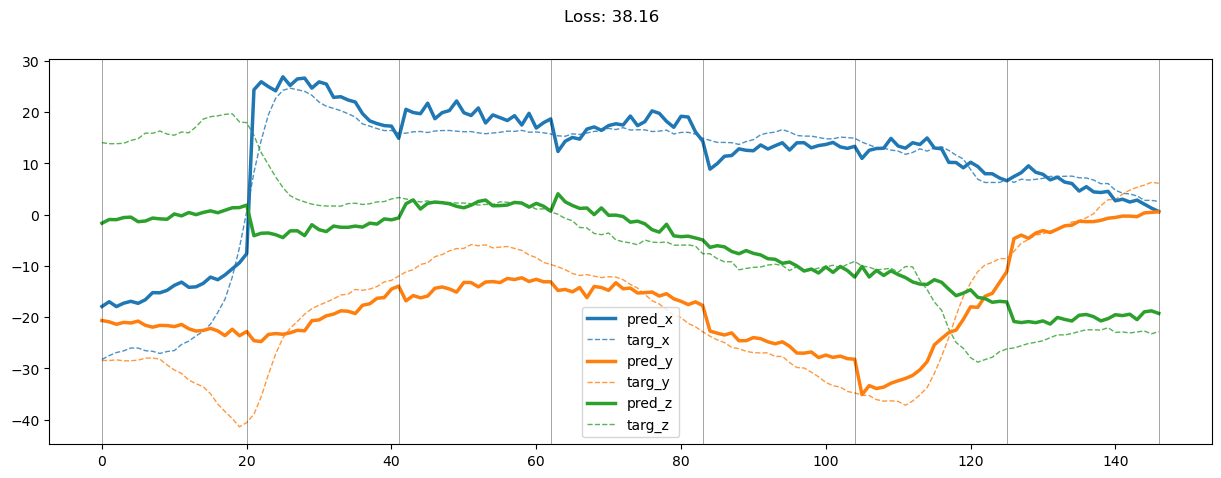

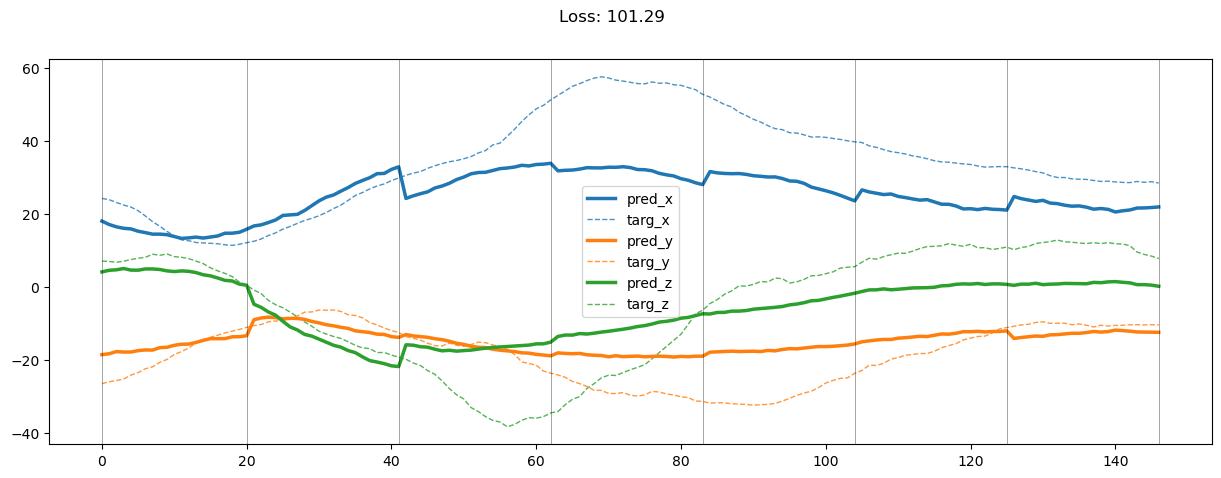

01199: train loss:  137.987, lin acc loss:  1.100, gro loss:  0.151, mag loss:  136.736
       valid loss:  159.219, lin acc loss:  0.918, gro loss:  0.143, mag loss:  158.158
01219: train loss:  129.368, lin acc loss:  1.124, gro loss:  0.150, mag loss:  128.094
       valid loss:  161.374, lin acc loss:  0.919, gro loss:  0.143, mag loss:  160.311
01239: train loss:  120.855, lin acc loss:  1.156, gro loss:  0.157, mag loss:  119.542
       valid loss:  154.480, lin acc loss:  0.920, gro loss:  0.143, mag loss:  153.417
01259: train loss:  116.493, lin acc loss:  1.106, gro loss:  0.151, mag loss:  115.236
       valid loss:  151.286, lin acc loss:  0.921, gro loss:  0.143, mag loss:  150.222
01279: train loss:  108.701, lin acc loss:  1.086, gro loss:  0.147, mag loss:  107.468
       valid loss:  143.422, lin acc loss:  0.920, gro loss:  0.144, mag loss:  142.357
01299: train loss:  103.084, lin acc loss:  1.090, gro loss:  0.147, mag loss:  101.847
       valid loss:  140.251, lin

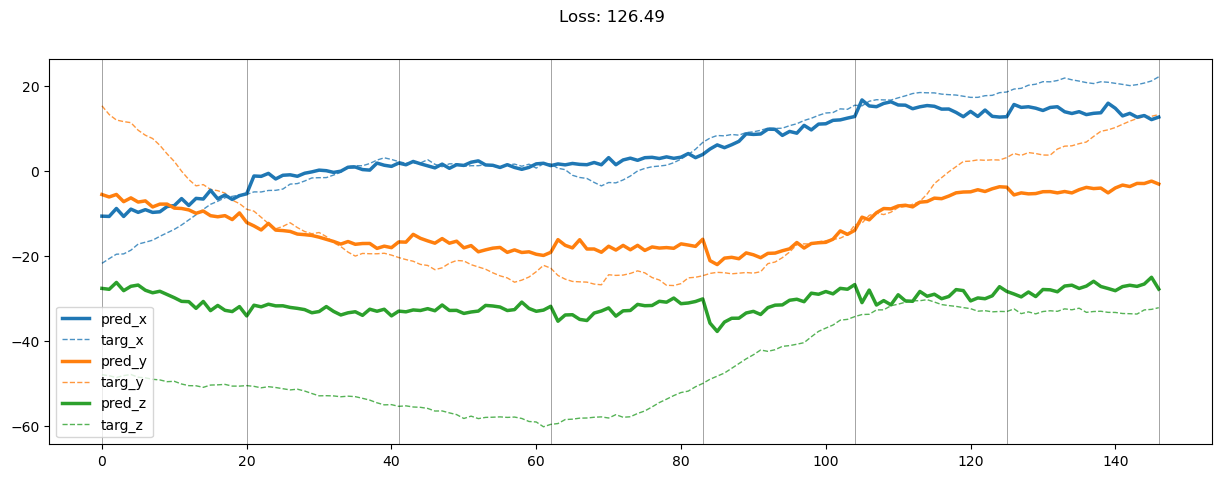

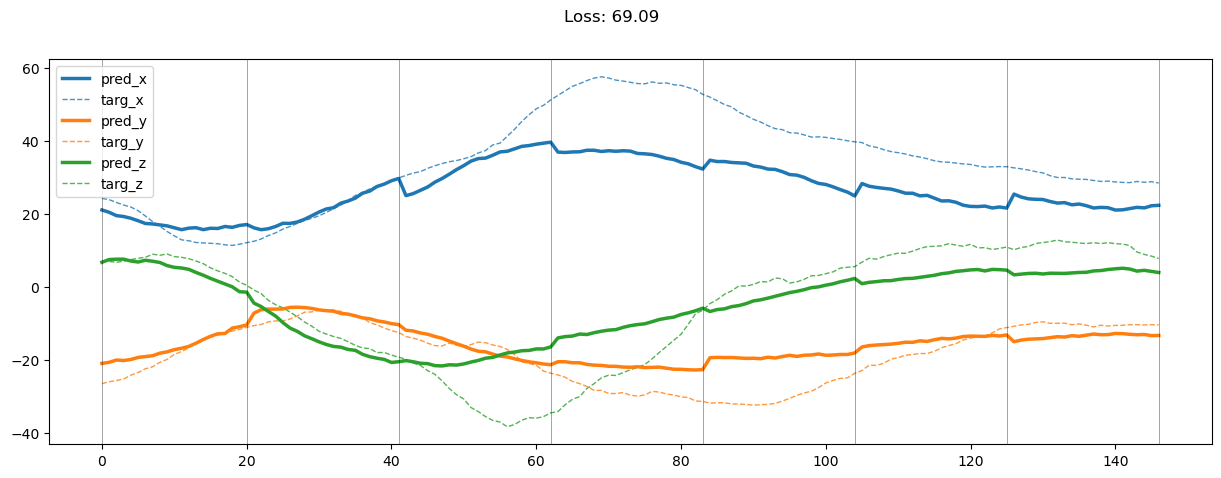

01399: train loss:  85.659, lin acc loss:  1.099, gro loss:  0.156, mag loss:  84.403
       valid loss:  116.345, lin acc loss:  0.921, gro loss:  0.143, mag loss:  115.280
01419: train loss:  80.629, lin acc loss:  1.089, gro loss:  0.140, mag loss:  79.400
       valid loss:  112.556, lin acc loss:  0.921, gro loss:  0.144, mag loss:  111.492
01439: train loss:  81.299, lin acc loss:  1.088, gro loss:  0.150, mag loss:  80.061
       valid loss:  110.770, lin acc loss:  0.920, gro loss:  0.143, mag loss:  109.707
01459: train loss:  72.215, lin acc loss:  1.119, gro loss:  0.149, mag loss:  70.946
       valid loss:  111.685, lin acc loss:  0.920, gro loss:  0.143, mag loss:  110.622
01479: train loss:  69.042, lin acc loss:  1.092, gro loss:  0.149, mag loss:  67.801
       valid loss:  106.956, lin acc loss:  0.920, gro loss:  0.142, mag loss:  105.894
01499: train loss:  73.283, lin acc loss:  1.104, gro loss:  0.156, mag loss:  72.024
       valid loss:  103.973, lin acc loss:  

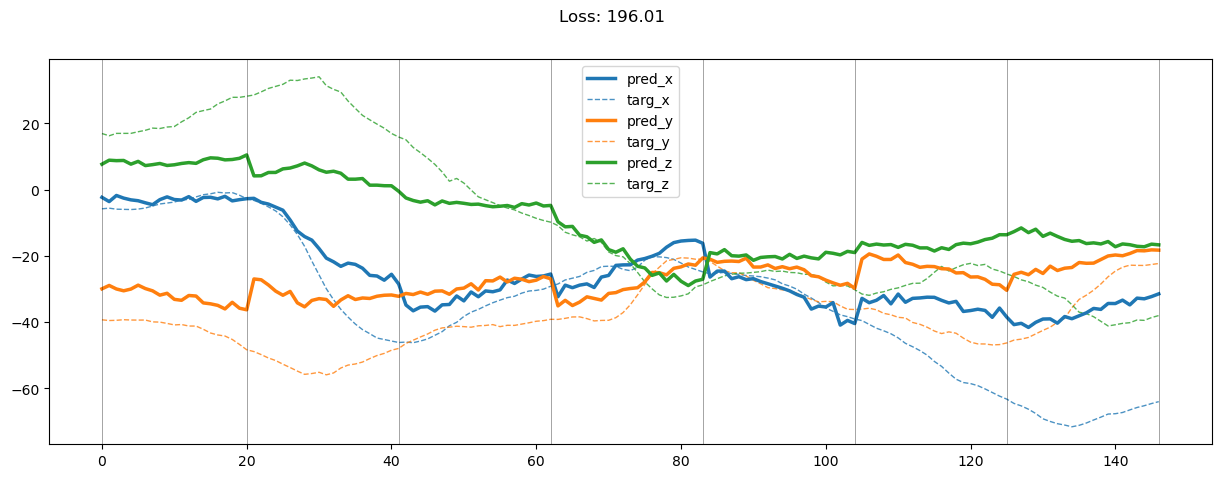

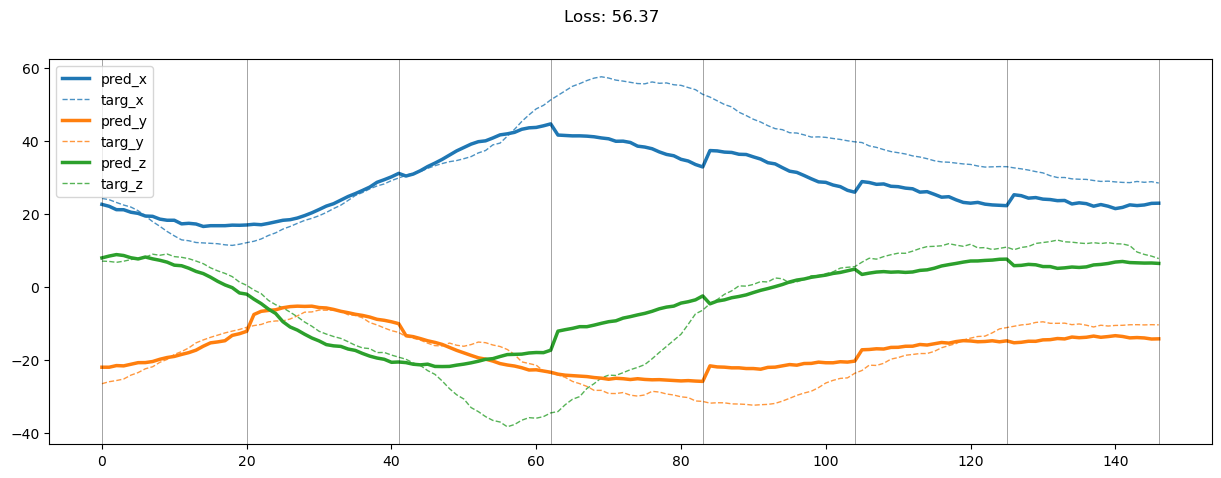

01599: train loss:  56.311, lin acc loss:  1.119, gro loss:  0.153, mag loss:  55.038
       valid loss:  94.113, lin acc loss:  0.919, gro loss:  0.141, mag loss:  93.053
01619: train loss:  53.799, lin acc loss:  1.067, gro loss:  0.153, mag loss:  52.579
       valid loss:  93.609, lin acc loss:  0.920, gro loss:  0.142, mag loss:  92.548
01639: train loss:  49.799, lin acc loss:  1.075, gro loss:  0.149, mag loss:  48.575
       valid loss:  83.467, lin acc loss:  0.919, gro loss:  0.141, mag loss:  82.407
01659: train loss:  45.518, lin acc loss:  1.080, gro loss:  0.154, mag loss:  44.284
       valid loss:  86.457, lin acc loss:  0.919, gro loss:  0.141, mag loss:  85.397
01679: train loss:  45.929, lin acc loss:  1.082, gro loss:  0.143, mag loss:  44.704
       valid loss:  85.157, lin acc loss:  0.919, gro loss:  0.141, mag loss:  84.097
01699: train loss:  44.242, lin acc loss:  1.165, gro loss:  0.154, mag loss:  42.923
       valid loss:  82.702, lin acc loss:  0.920, gro 

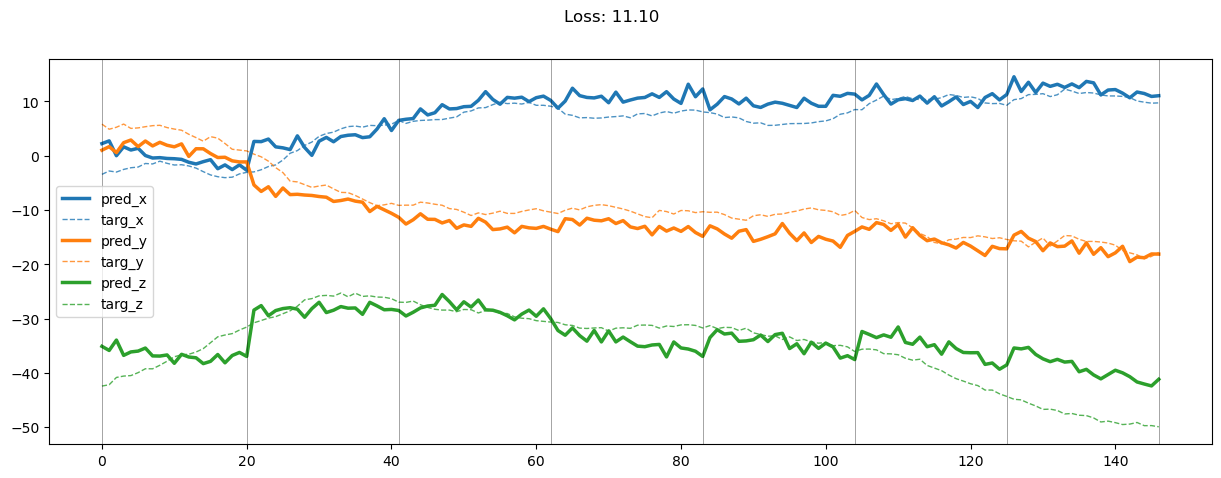

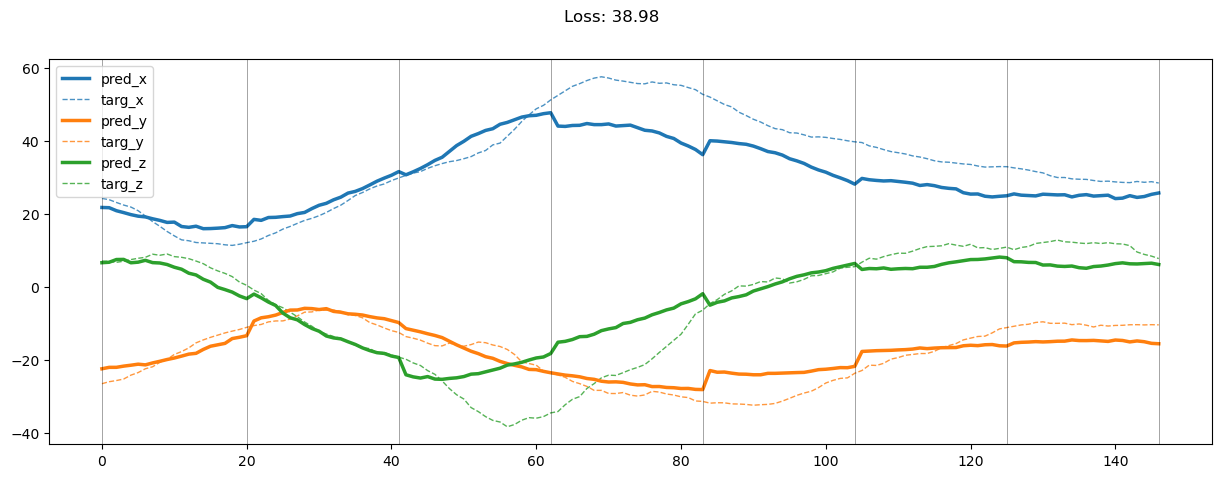

01799: train loss:  37.105, lin acc loss:  1.104, gro loss:  0.152, mag loss:  35.849
       valid loss:  73.069, lin acc loss:  0.917, gro loss:  0.140, mag loss:  72.013
01819: train loss:  36.003, lin acc loss:  1.082, gro loss:  0.147, mag loss:  34.774
       valid loss:  71.925, lin acc loss:  0.916, gro loss:  0.140, mag loss:  70.869
01839: train loss:  33.680, lin acc loss:  1.081, gro loss:  0.138, mag loss:  32.461
       valid loss:  73.006, lin acc loss:  0.916, gro loss:  0.139, mag loss:  71.950
01859: train loss:  34.899, lin acc loss:  1.116, gro loss:  0.150, mag loss:  33.633
       valid loss:  72.702, lin acc loss:  0.916, gro loss:  0.139, mag loss:  71.647
01879: train loss:  31.733, lin acc loss:  1.123, gro loss:  0.150, mag loss:  30.460
       valid loss:  69.879, lin acc loss:  0.916, gro loss:  0.139, mag loss:  68.823
01899: train loss:  27.646, lin acc loss:  1.107, gro loss:  0.149, mag loss:  26.391
       valid loss:  68.775, lin acc loss:  0.916, gro 

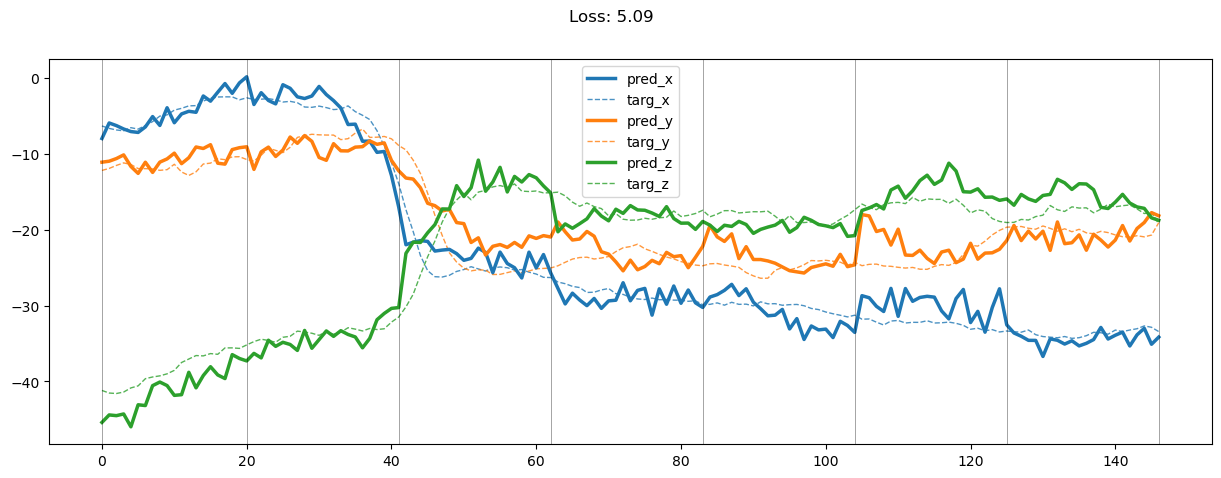

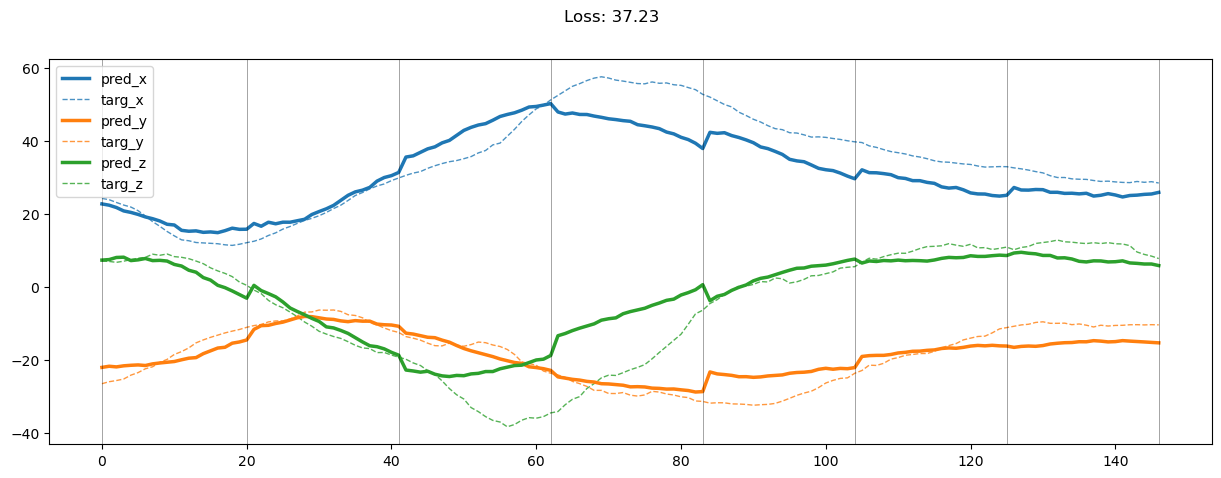

01999: train loss:  24.595, lin acc loss:  1.065, gro loss:  0.145, mag loss:  23.386
       valid loss:  70.090, lin acc loss:  0.914, gro loss:  0.138, mag loss:  69.038
02019: train loss:  26.147, lin acc loss:  1.112, gro loss:  0.150, mag loss:  24.885
       valid loss:  64.143, lin acc loss:  0.914, gro loss:  0.138, mag loss:  63.091
02039: train loss:  22.643, lin acc loss:  1.087, gro loss:  0.149, mag loss:  21.407
       valid loss:  62.190, lin acc loss:  0.914, gro loss:  0.138, mag loss:  61.139
02059: train loss:  22.850, lin acc loss:  1.072, gro loss:  0.142, mag loss:  21.636
       valid loss:  66.506, lin acc loss:  0.913, gro loss:  0.138, mag loss:  65.455
02079: train loss:  22.927, lin acc loss:  1.051, gro loss:  0.142, mag loss:  21.734
       valid loss:  66.004, lin acc loss:  0.914, gro loss:  0.138, mag loss:  64.952
02099: train loss:  23.069, lin acc loss:  1.089, gro loss:  0.139, mag loss:  21.841
       valid loss:  64.933, lin acc loss:  0.913, gro 

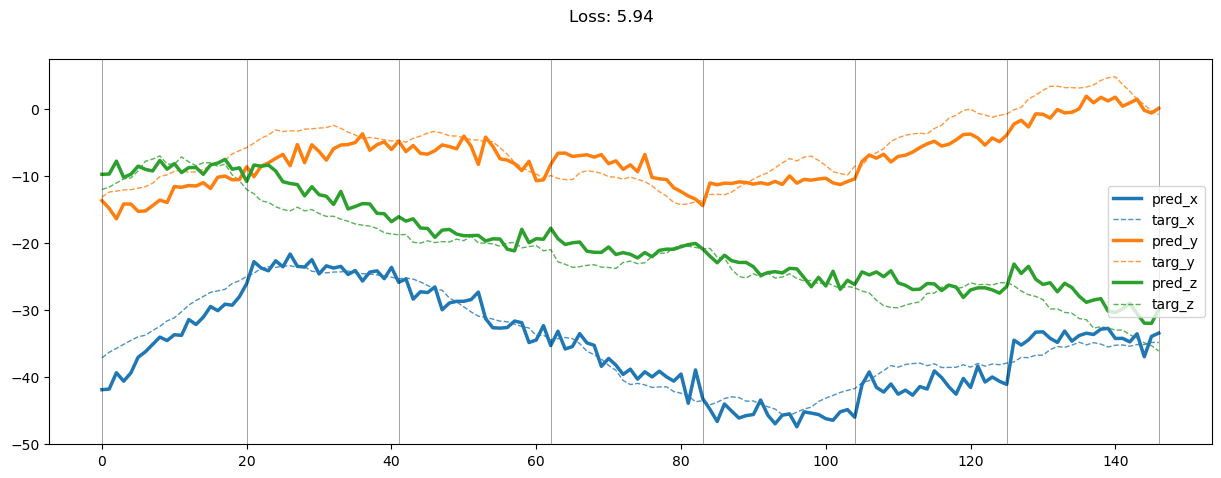

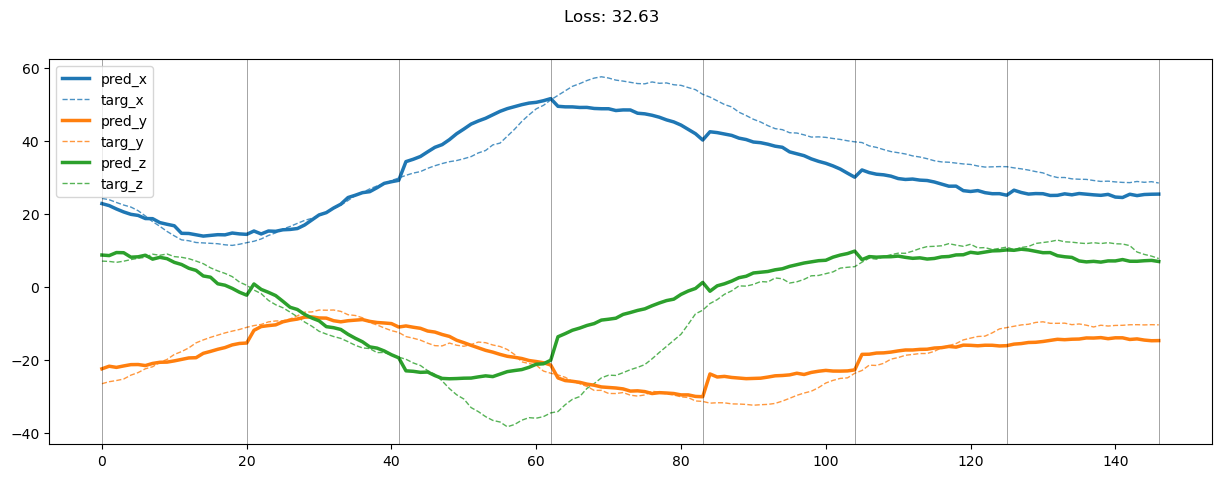

02199: train loss:  18.778, lin acc loss:  1.146, gro loss:  0.145, mag loss:  17.486
       valid loss:  61.214, lin acc loss:  0.912, gro loss:  0.137, mag loss:  60.165
02219: train loss:  19.162, lin acc loss:  1.067, gro loss:  0.145, mag loss:  17.950
       valid loss:  75.879, lin acc loss:  0.911, gro loss:  0.138, mag loss:  74.830
02239: train loss:  18.528, lin acc loss:  1.099, gro loss:  0.147, mag loss:  17.281
       valid loss:  70.838, lin acc loss:  0.911, gro loss:  0.138, mag loss:  69.789
02259: train loss:  17.538, lin acc loss:  1.090, gro loss:  0.140, mag loss:  16.308
       valid loss:  64.797, lin acc loss:  0.911, gro loss:  0.137, mag loss:  63.748
02279: train loss:  16.535, lin acc loss:  1.049, gro loss:  0.142, mag loss:  15.344
       valid loss:  59.336, lin acc loss:  0.911, gro loss:  0.137, mag loss:  58.288
02299: train loss:  18.592, lin acc loss:  1.088, gro loss:  0.138, mag loss:  17.366
       valid loss:  57.493, lin acc loss:  0.911, gro 

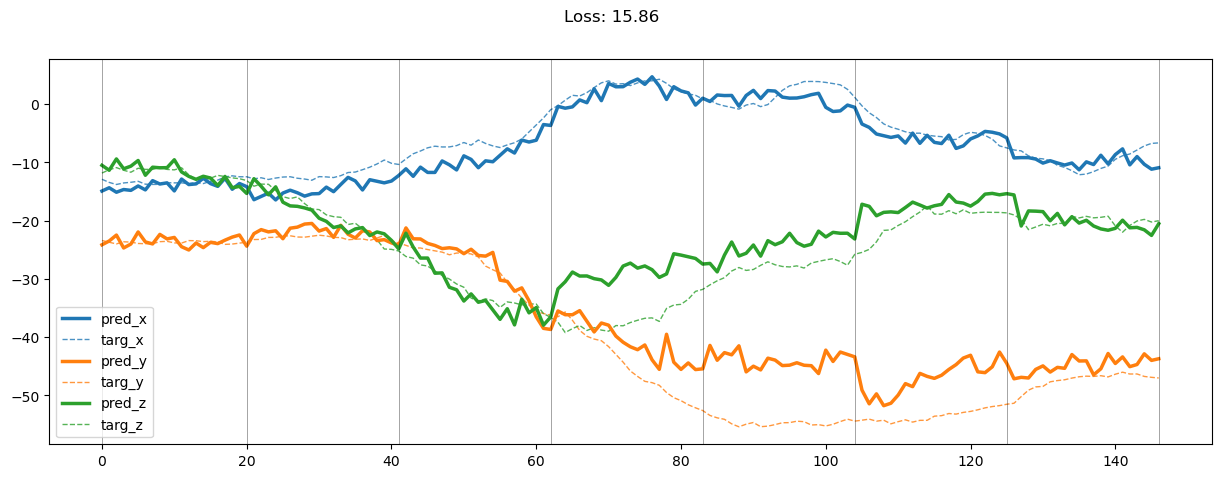

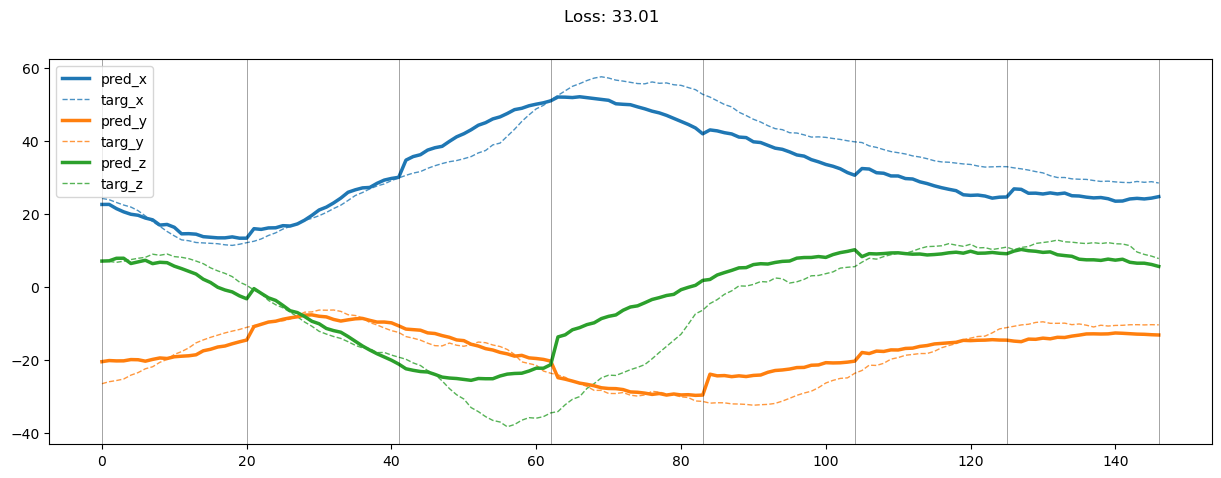

02399: train loss:  15.744, lin acc loss:  1.084, gro loss:  0.140, mag loss:  14.521
       valid loss:  55.100, lin acc loss:  0.911, gro loss:  0.137, mag loss:  54.053
02419: train loss:  14.336, lin acc loss:  1.128, gro loss:  0.151, mag loss:  13.057
       valid loss:  59.517, lin acc loss:  0.909, gro loss:  0.136, mag loss:  58.471
02439: train loss:  13.699, lin acc loss:  1.040, gro loss:  0.135, mag loss:  12.524
       valid loss:  58.197, lin acc loss:  0.909, gro loss:  0.136, mag loss:  57.152
02459: train loss:  15.721, lin acc loss:  1.123, gro loss:  0.141, mag loss:  14.456
       valid loss:  59.039, lin acc loss:  0.910, gro loss:  0.136, mag loss:  57.993
02479: train loss:  14.090, lin acc loss:  1.102, gro loss:  0.145, mag loss:  12.843
       valid loss:  54.417, lin acc loss:  0.909, gro loss:  0.136, mag loss:  53.371
02499: train loss:  13.722, lin acc loss:  1.106, gro loss:  0.147, mag loss:  12.469
       valid loss:  54.954, lin acc loss:  0.909, gro 

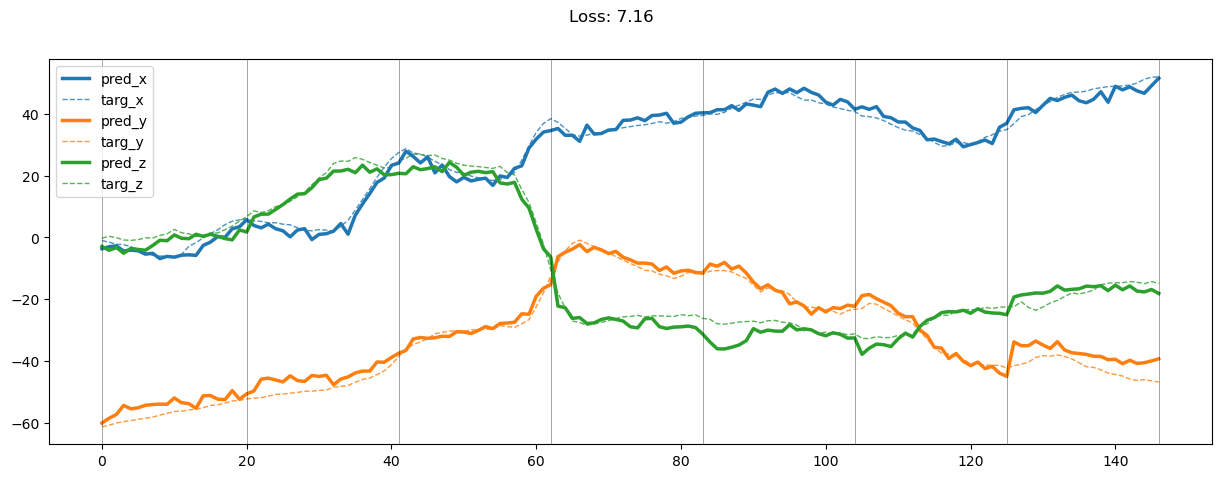

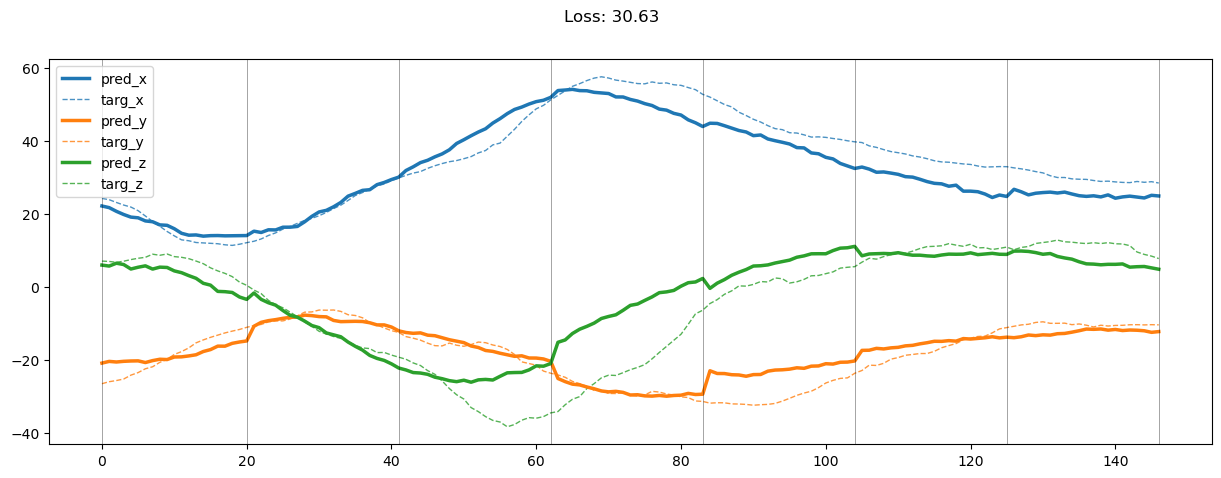

02599: train loss:  11.340, lin acc loss:  1.129, gro loss:  0.146, mag loss:  10.065
       valid loss:  55.149, lin acc loss:  0.909, gro loss:  0.136, mag loss:  54.104
02619: train loss:  12.534, lin acc loss:  1.112, gro loss:  0.141, mag loss:  11.280
       valid loss:  51.516, lin acc loss:  0.909, gro loss:  0.136, mag loss:  50.471
02639: train loss:  12.008, lin acc loss:  1.087, gro loss:  0.143, mag loss:  10.778
       valid loss:  55.908, lin acc loss:  0.909, gro loss:  0.136, mag loss:  54.863
02659: train loss:  11.246, lin acc loss:  1.074, gro loss:  0.141, mag loss:  10.032
       valid loss:  51.768, lin acc loss:  0.909, gro loss:  0.136, mag loss:  50.723
02679: train loss:  10.916, lin acc loss:  1.103, gro loss:  0.144, mag loss:  9.669
       valid loss:  51.056, lin acc loss:  0.908, gro loss:  0.136, mag loss:  50.012
02699: train loss:  10.386, lin acc loss:  1.105, gro loss:  0.151, mag loss:  9.130
       valid loss:  53.270, lin acc loss:  0.908, gro lo

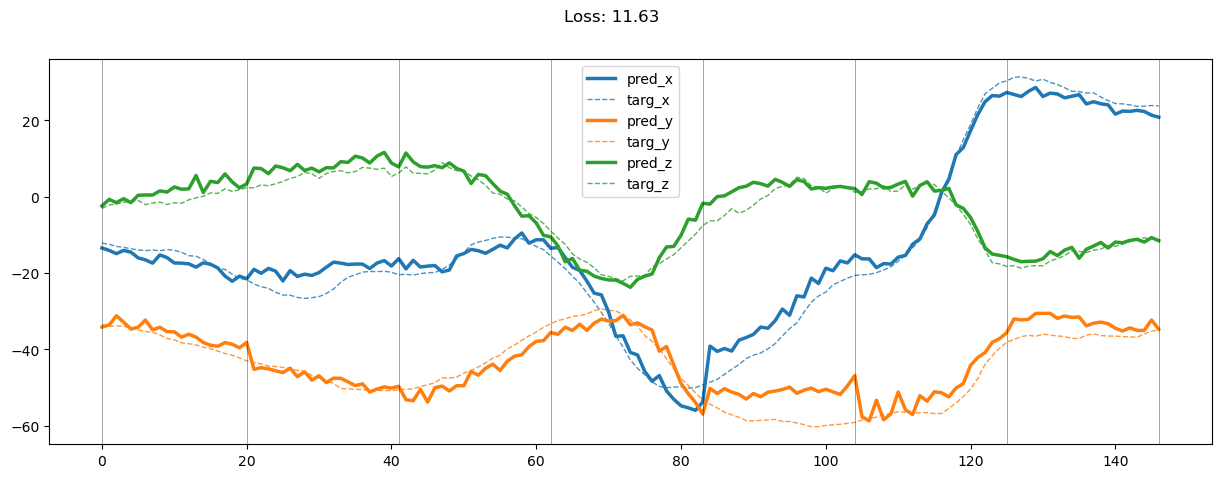

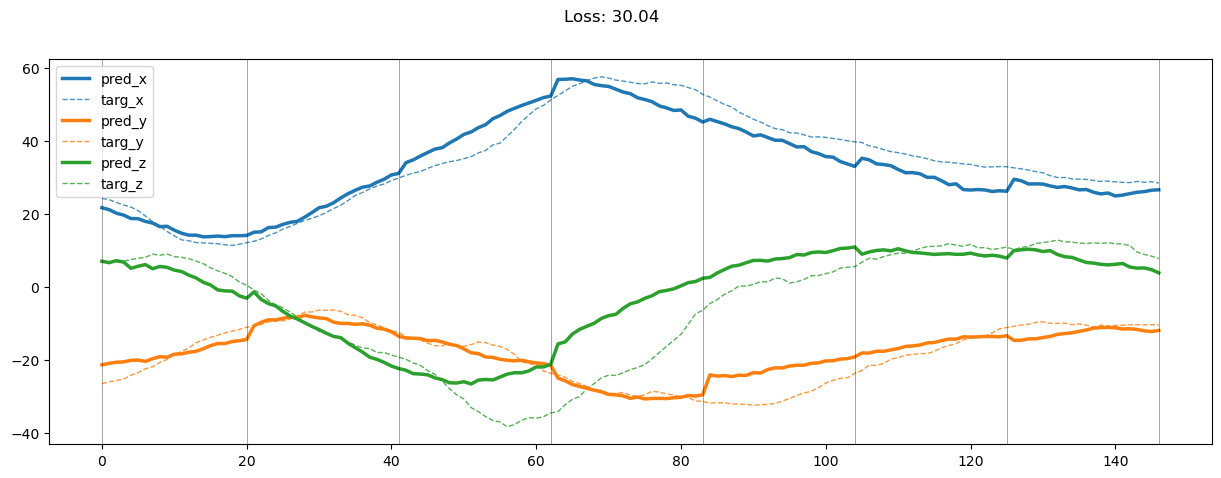

02799: train loss:  11.078, lin acc loss:  1.124, gro loss:  0.146, mag loss:  9.808
       valid loss:  51.337, lin acc loss:  0.908, gro loss:  0.136, mag loss:  50.294
02819: train loss:  9.550, lin acc loss:  1.087, gro loss:  0.141, mag loss:  8.321
       valid loss:  52.393, lin acc loss:  0.907, gro loss:  0.136, mag loss:  51.350
02839: train loss:  9.117, lin acc loss:  1.098, gro loss:  0.144, mag loss:  7.875
       valid loss:  50.117, lin acc loss:  0.907, gro loss:  0.136, mag loss:  49.074
02859: train loss:  9.665, lin acc loss:  1.099, gro loss:  0.136, mag loss:  8.430
       valid loss:  54.299, lin acc loss:  0.908, gro loss:  0.136, mag loss:  53.256
02879: train loss:  9.786, lin acc loss:  1.084, gro loss:  0.139, mag loss:  8.564
       valid loss:  50.385, lin acc loss:  0.907, gro loss:  0.135, mag loss:  49.342
02899: train loss:  10.272, lin acc loss:  1.079, gro loss:  0.137, mag loss:  9.057
       valid loss:  47.206, lin acc loss:  0.907, gro loss:  0.1

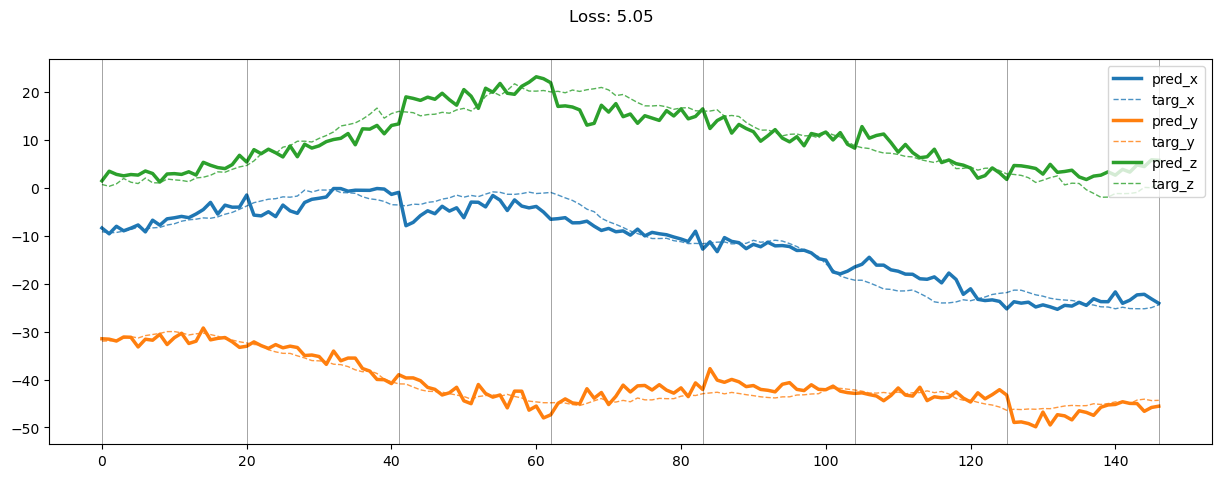

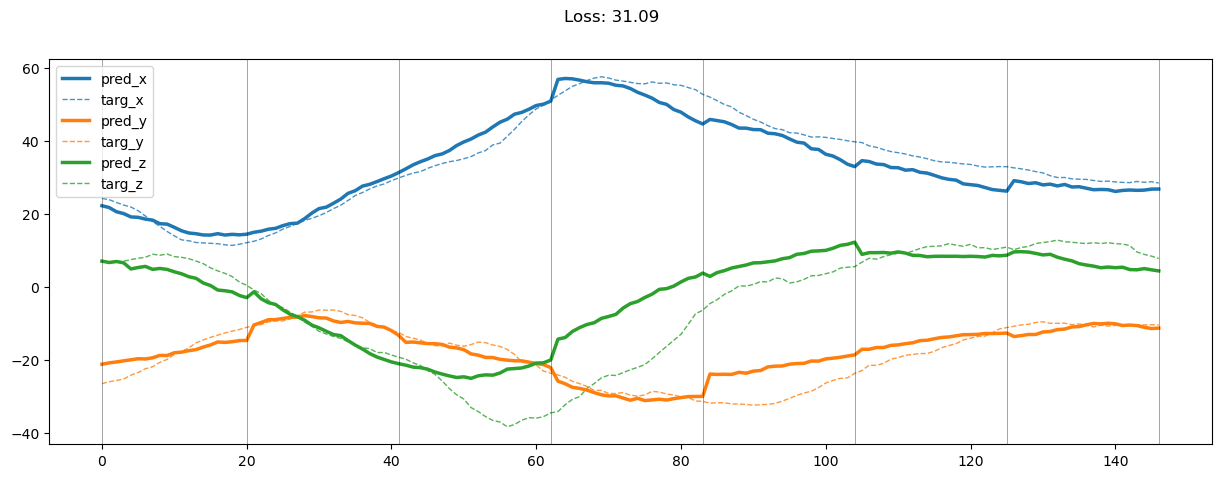

02999: train loss:  8.634, lin acc loss:  1.133, gro loss:  0.141, mag loss:  7.360
       valid loss:  43.208, lin acc loss:  0.906, gro loss:  0.135, mag loss:  42.167
03019: train loss:  9.338, lin acc loss:  1.123, gro loss:  0.144, mag loss:  8.071
       valid loss:  49.995, lin acc loss:  0.907, gro loss:  0.135, mag loss:  48.953
03039: train loss:  8.726, lin acc loss:  1.129, gro loss:  0.147, mag loss:  7.450
       valid loss:  50.753, lin acc loss:  0.907, gro loss:  0.135, mag loss:  49.711
03059: train loss:  8.571, lin acc loss:  1.078, gro loss:  0.140, mag loss:  7.353
       valid loss:  47.335, lin acc loss:  0.908, gro loss:  0.134, mag loss:  46.293
03079: train loss:  8.242, lin acc loss:  1.094, gro loss:  0.138, mag loss:  7.009
       valid loss:  49.953, lin acc loss:  0.907, gro loss:  0.134, mag loss:  48.911
03099: train loss:  8.080, lin acc loss:  1.091, gro loss:  0.143, mag loss:  6.846
       valid loss:  47.680, lin acc loss:  0.907, gro loss:  0.134

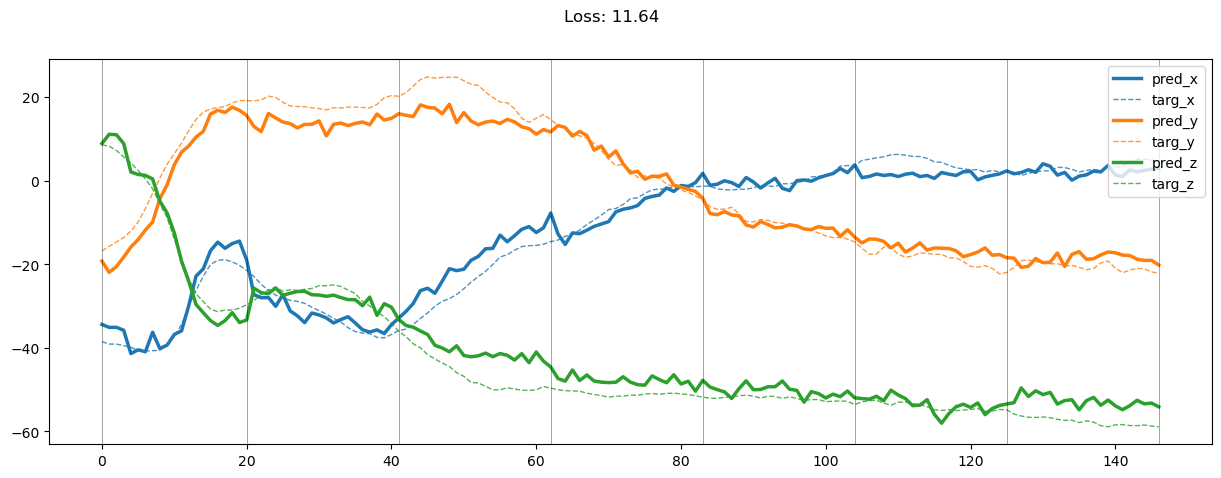

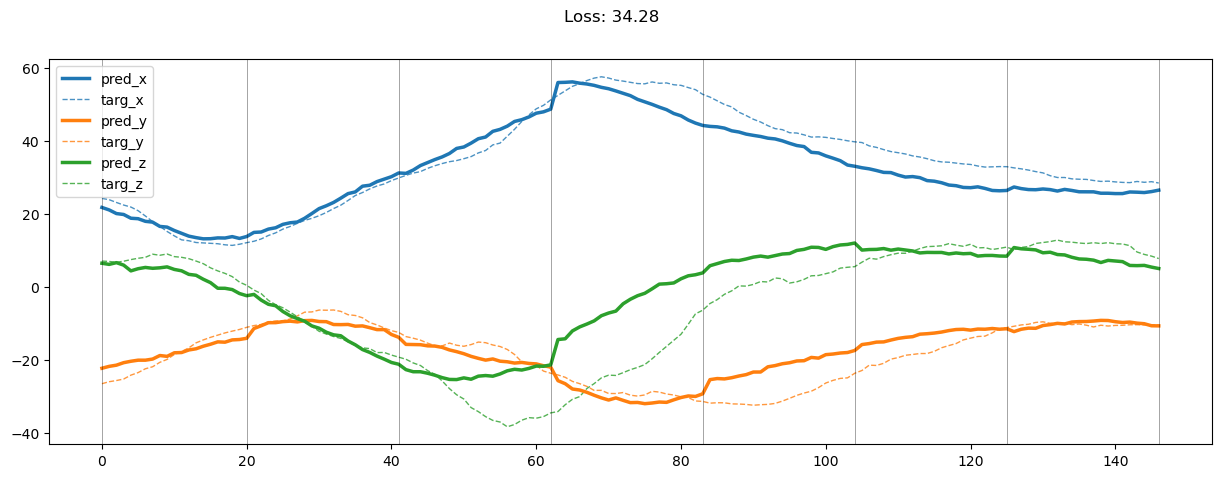

03199: train loss:  7.458, lin acc loss:  1.115, gro loss:  0.142, mag loss:  6.200
       valid loss:  44.838, lin acc loss:  0.907, gro loss:  0.133, mag loss:  43.798
03219: train loss:  6.972, lin acc loss:  1.060, gro loss:  0.129, mag loss:  5.783
       valid loss:  46.702, lin acc loss:  0.907, gro loss:  0.134, mag loss:  45.662
03239: train loss:  7.568, lin acc loss:  1.079, gro loss:  0.133, mag loss:  6.356
       valid loss:  45.396, lin acc loss:  0.907, gro loss:  0.134, mag loss:  44.355
03259: train loss:  7.366, lin acc loss:  1.157, gro loss:  0.143, mag loss:  6.067
       valid loss:  44.232, lin acc loss:  0.906, gro loss:  0.134, mag loss:  43.191
03279: train loss:  6.901, lin acc loss:  1.073, gro loss:  0.137, mag loss:  5.691
       valid loss:  47.218, lin acc loss:  0.907, gro loss:  0.133, mag loss:  46.178
03299: train loss:  7.084, lin acc loss:  1.080, gro loss:  0.137, mag loss:  5.867
       valid loss:  47.592, lin acc loss:  0.907, gro loss:  0.133

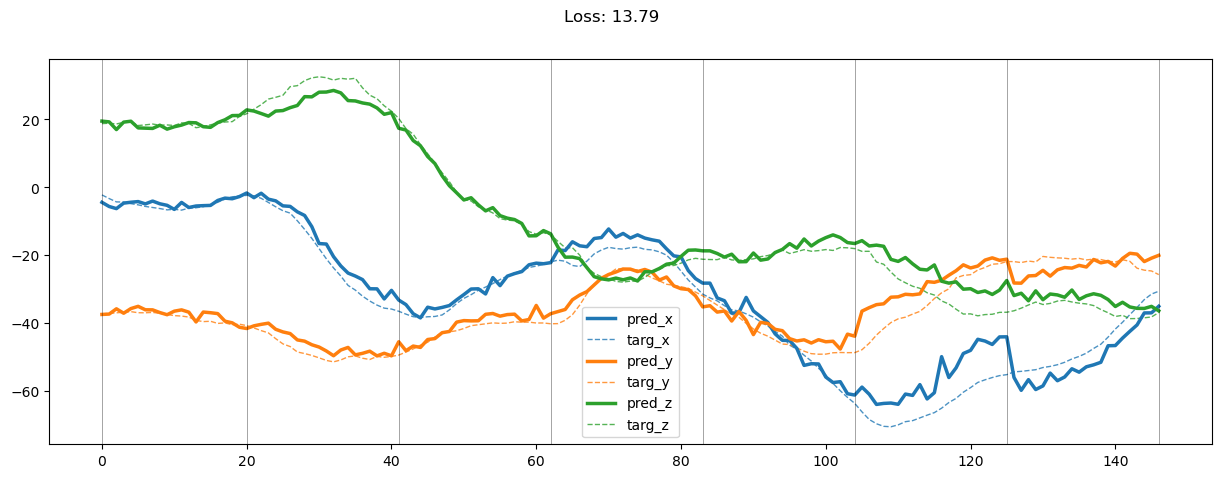

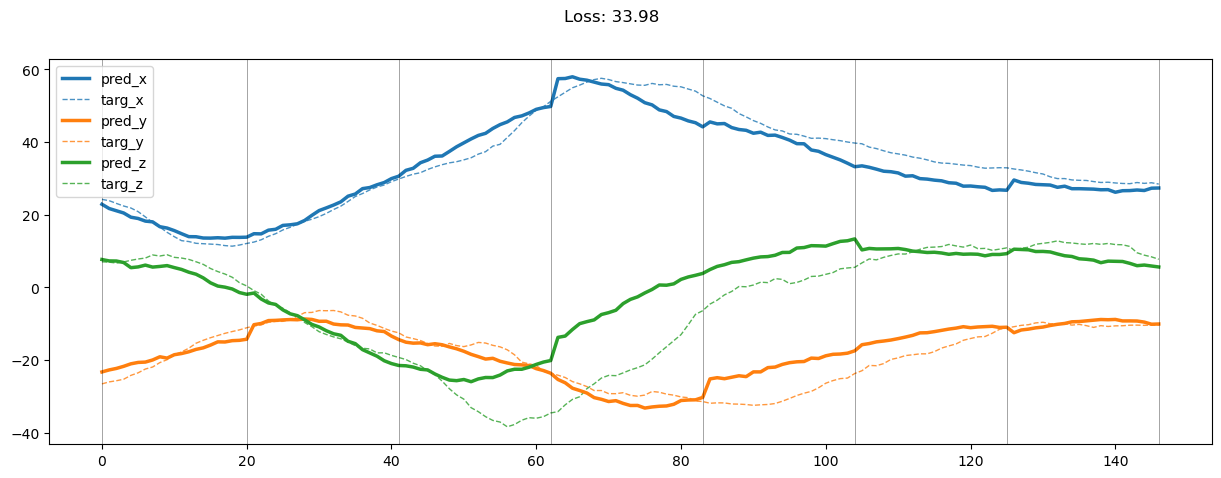

03399: train loss:  6.809, lin acc loss:  1.089, gro loss:  0.134, mag loss:  5.586
       valid loss:  47.415, lin acc loss:  0.906, gro loss:  0.133, mag loss:  46.375
03419: train loss:  8.423, lin acc loss:  1.081, gro loss:  0.140, mag loss:  7.202
       valid loss:  48.873, lin acc loss:  0.907, gro loss:  0.132, mag loss:  47.834
03439: train loss:  26.500, lin acc loss:  1.088, gro loss:  0.137, mag loss:  25.275
       valid loss:  138.963, lin acc loss:  0.910, gro loss:  0.136, mag loss:  137.918
03459: train loss:  25.262, lin acc loss:  1.079, gro loss:  0.134, mag loss:  24.048
       valid loss:  87.452, lin acc loss:  0.908, gro loss:  0.135, mag loss:  86.409
03479: train loss:  9.687, lin acc loss:  1.060, gro loss:  0.132, mag loss:  8.495
       valid loss:  37.637, lin acc loss:  0.907, gro loss:  0.134, mag loss:  36.596
03499: train loss:  8.122, lin acc loss:  1.055, gro loss:  0.134, mag loss:  6.933
       valid loss:  42.605, lin acc loss:  0.907, gro loss: 

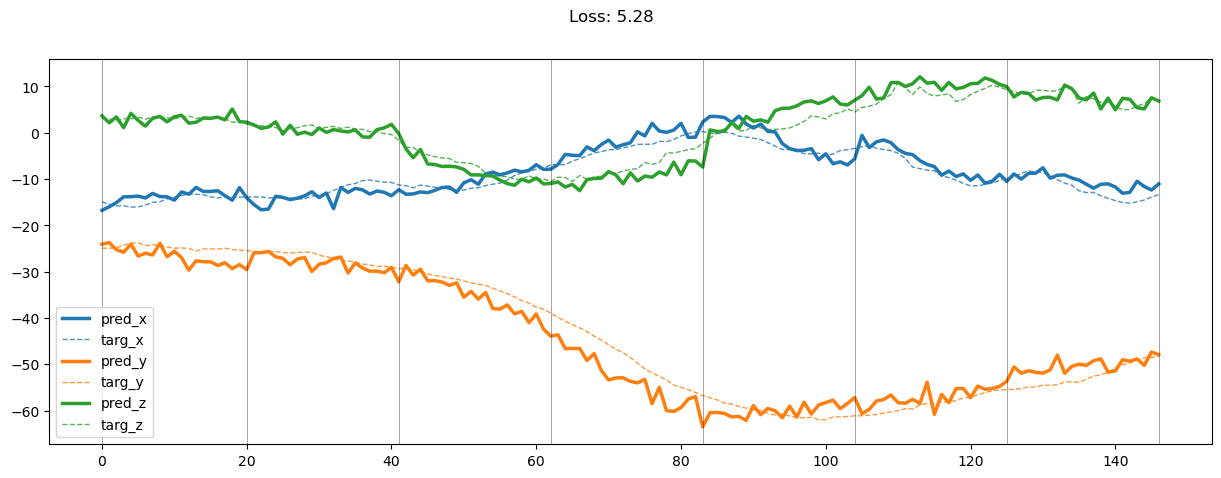

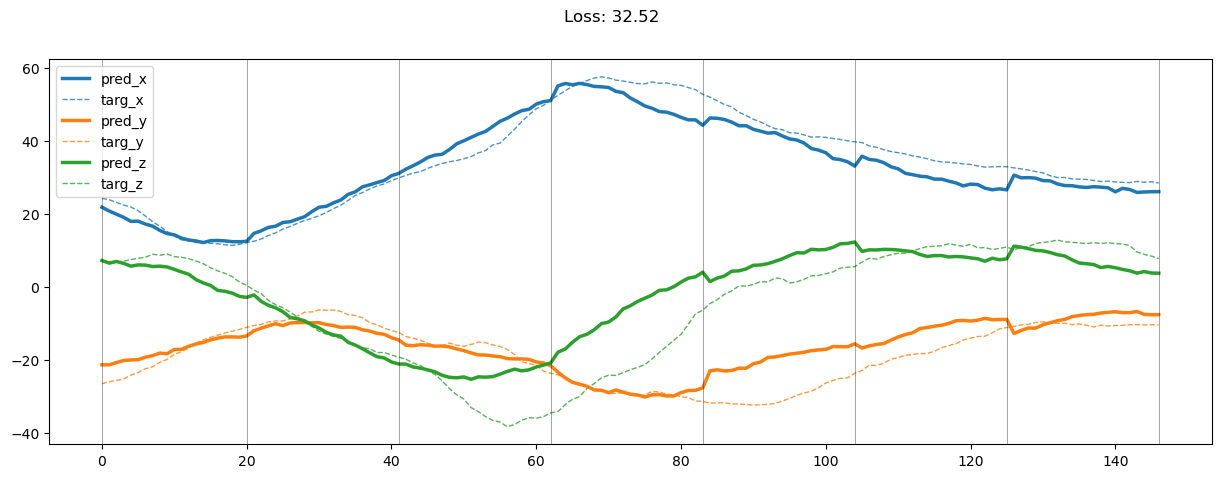

03599: train loss:  6.700, lin acc loss:  1.092, gro loss:  0.136, mag loss:  5.472
       valid loss:  41.832, lin acc loss:  0.906, gro loss:  0.132, mag loss:  40.794
03619: train loss:  6.555, lin acc loss:  1.144, gro loss:  0.140, mag loss:  5.271
       valid loss:  43.546, lin acc loss:  0.906, gro loss:  0.132, mag loss:  42.507
03639: train loss:  6.393, lin acc loss:  1.091, gro loss:  0.131, mag loss:  5.172
       valid loss:  41.663, lin acc loss:  0.907, gro loss:  0.132, mag loss:  40.624
03659: train loss:  6.251, lin acc loss:  1.086, gro loss:  0.148, mag loss:  5.017
       valid loss:  40.764, lin acc loss:  0.906, gro loss:  0.132, mag loss:  39.726
03679: train loss:  6.306, lin acc loss:  1.033, gro loss:  0.131, mag loss:  5.142
       valid loss:  39.575, lin acc loss:  0.906, gro loss:  0.132, mag loss:  38.537
03699: train loss:  6.314, lin acc loss:  1.057, gro loss:  0.133, mag loss:  5.124
       valid loss:  40.867, lin acc loss:  0.906, gro loss:  0.132

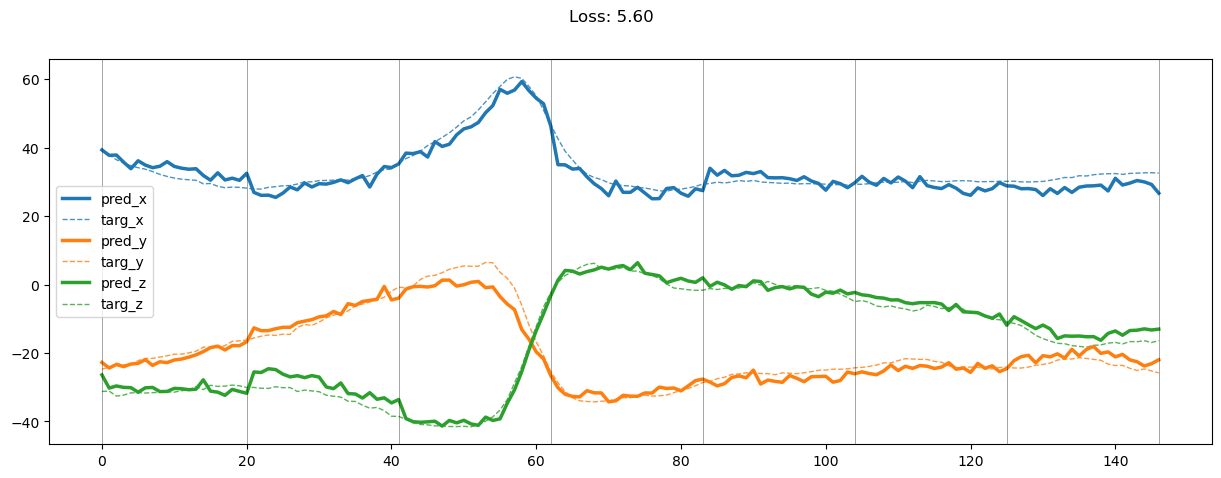

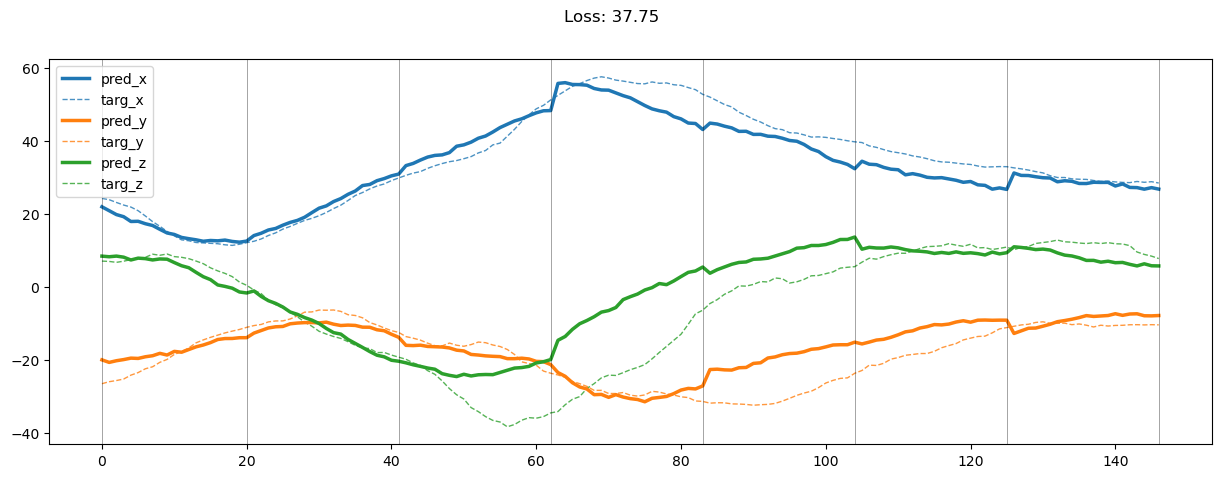

03799: train loss:  5.732, lin acc loss:  1.123, gro loss:  0.145, mag loss:  4.463
       valid loss:  42.920, lin acc loss:  0.906, gro loss:  0.132, mag loss:  41.882
03819: train loss:  5.788, lin acc loss:  1.080, gro loss:  0.132, mag loss:  4.576
       valid loss:  42.365, lin acc loss:  0.906, gro loss:  0.132, mag loss:  41.327
03839: train loss:  5.659, lin acc loss:  1.098, gro loss:  0.130, mag loss:  4.431
       valid loss:  41.549, lin acc loss:  0.905, gro loss:  0.132, mag loss:  40.512
03859: train loss:  5.566, lin acc loss:  1.029, gro loss:  0.130, mag loss:  4.407
       valid loss:  42.578, lin acc loss:  0.906, gro loss:  0.132, mag loss:  41.541
03879: train loss:  5.793, lin acc loss:  1.103, gro loss:  0.133, mag loss:  4.557
       valid loss:  42.613, lin acc loss:  0.906, gro loss:  0.132, mag loss:  41.576
03899: train loss:  5.256, lin acc loss:  1.073, gro loss:  0.133, mag loss:  4.050
       valid loss:  41.551, lin acc loss:  0.905, gro loss:  0.131

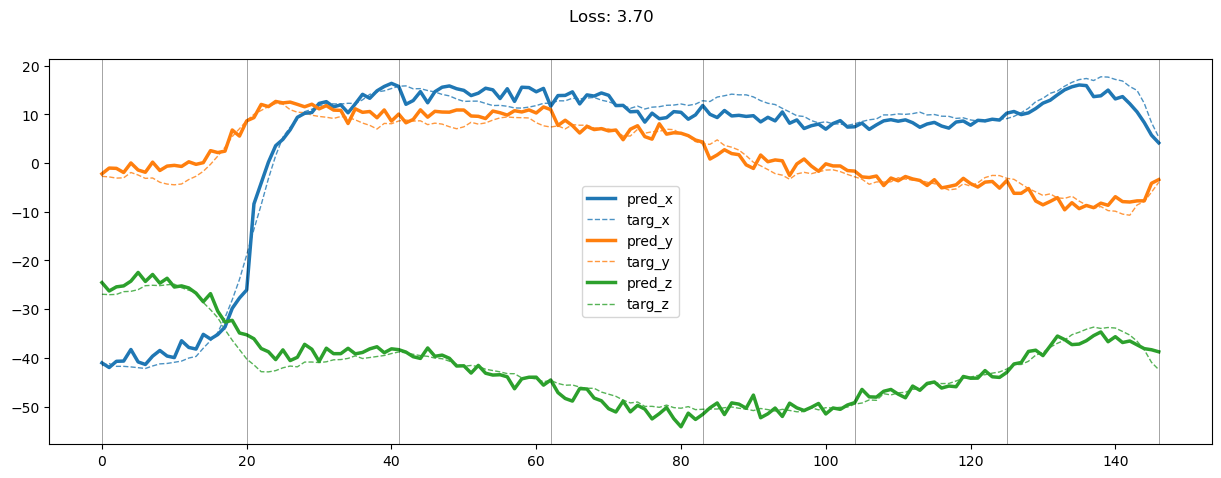

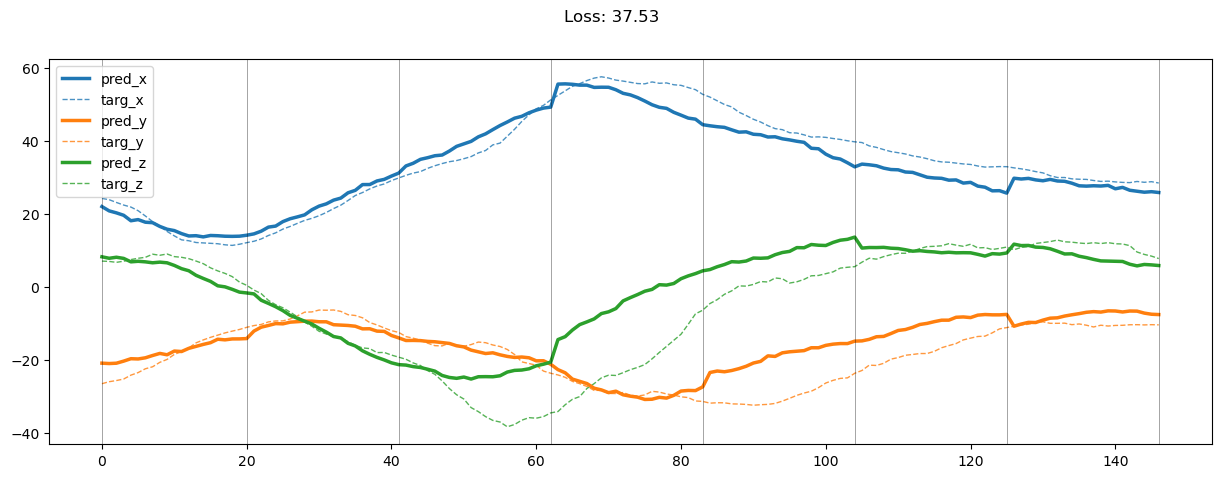

03999: train loss:  5.255, lin acc loss:  1.067, gro loss:  0.133, mag loss:  4.055
       valid loss:  42.029, lin acc loss:  0.905, gro loss:  0.131, mag loss:  40.993
04019: train loss:  5.081, lin acc loss:  1.042, gro loss:  0.129, mag loss:  3.910
       valid loss:  42.783, lin acc loss:  0.905, gro loss:  0.131, mag loss:  41.747
04039: train loss:  5.241, lin acc loss:  1.059, gro loss:  0.126, mag loss:  4.057
       valid loss:  41.052, lin acc loss:  0.905, gro loss:  0.131, mag loss:  40.015
04059: train loss:  5.491, lin acc loss:  1.035, gro loss:  0.133, mag loss:  4.323
       valid loss:  41.561, lin acc loss:  0.905, gro loss:  0.131, mag loss:  40.525
04079: train loss:  5.240, lin acc loss:  1.085, gro loss:  0.134, mag loss:  4.021
       valid loss:  42.662, lin acc loss:  0.906, gro loss:  0.131, mag loss:  41.625
04099: train loss:  4.955, lin acc loss:  1.081, gro loss:  0.128, mag loss:  3.746
       valid loss:  41.844, lin acc loss:  0.905, gro loss:  0.130

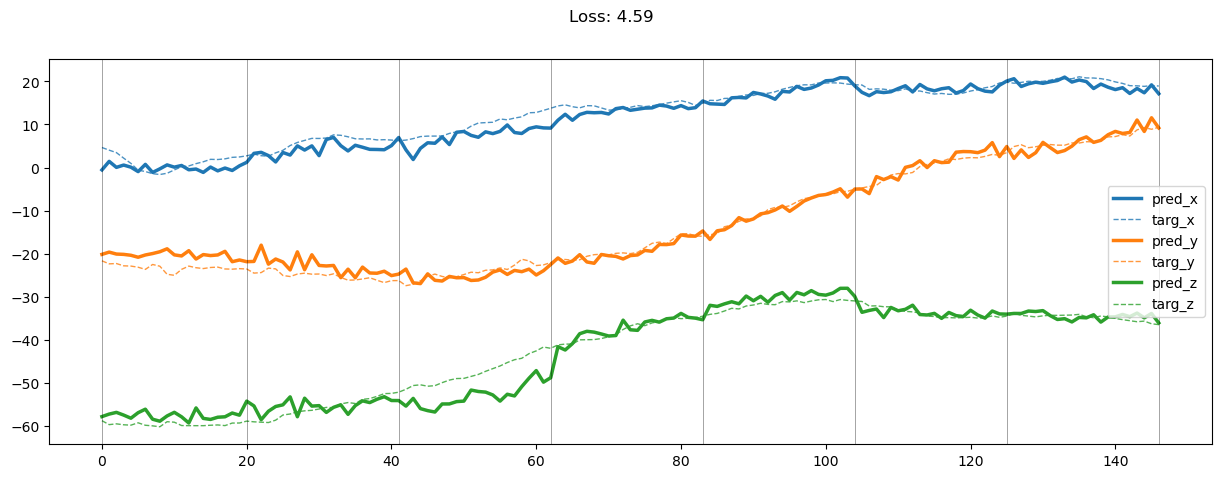

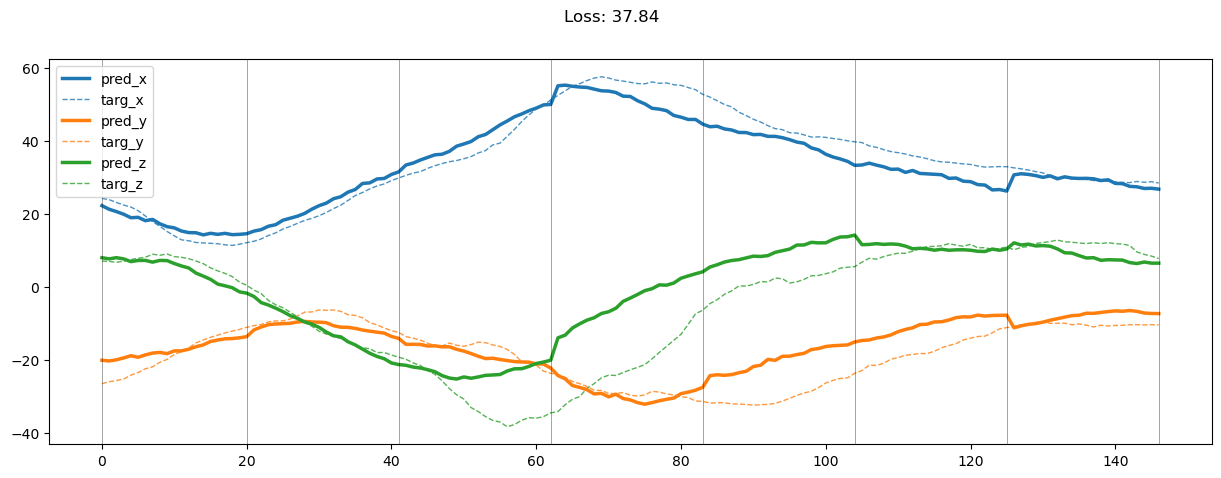

04199: train loss:  4.872, lin acc loss:  1.073, gro loss:  0.127, mag loss:  3.673
       valid loss:  43.255, lin acc loss:  0.905, gro loss:  0.130, mag loss:  42.220
04219: train loss:  4.567, lin acc loss:  1.058, gro loss:  0.125, mag loss:  3.384
       valid loss:  43.994, lin acc loss:  0.905, gro loss:  0.130, mag loss:  42.959
04239: train loss:  4.620, lin acc loss:  1.029, gro loss:  0.122, mag loss:  3.470
       valid loss:  42.462, lin acc loss:  0.905, gro loss:  0.130, mag loss:  41.427
04259: train loss:  4.732, lin acc loss:  1.064, gro loss:  0.127, mag loss:  3.541
       valid loss:  43.275, lin acc loss:  0.905, gro loss:  0.130, mag loss:  42.239
04279: train loss:  4.717, lin acc loss:  1.066, gro loss:  0.132, mag loss:  3.519
       valid loss:  40.036, lin acc loss:  0.905, gro loss:  0.130, mag loss:  39.002
04299: train loss:  4.936, lin acc loss:  1.073, gro loss:  0.134, mag loss:  3.729
       valid loss:  40.376, lin acc loss:  0.906, gro loss:  0.130

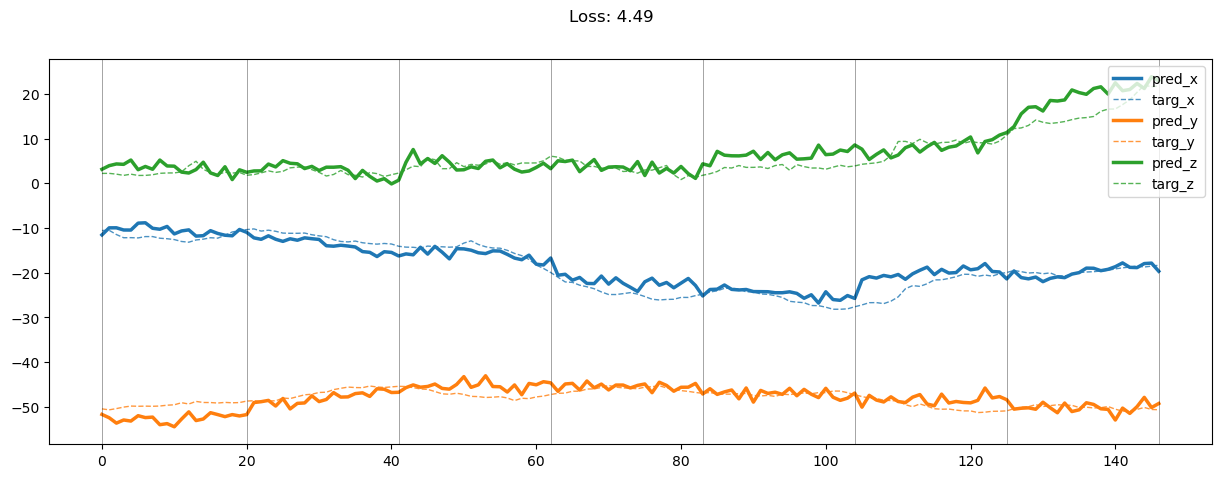

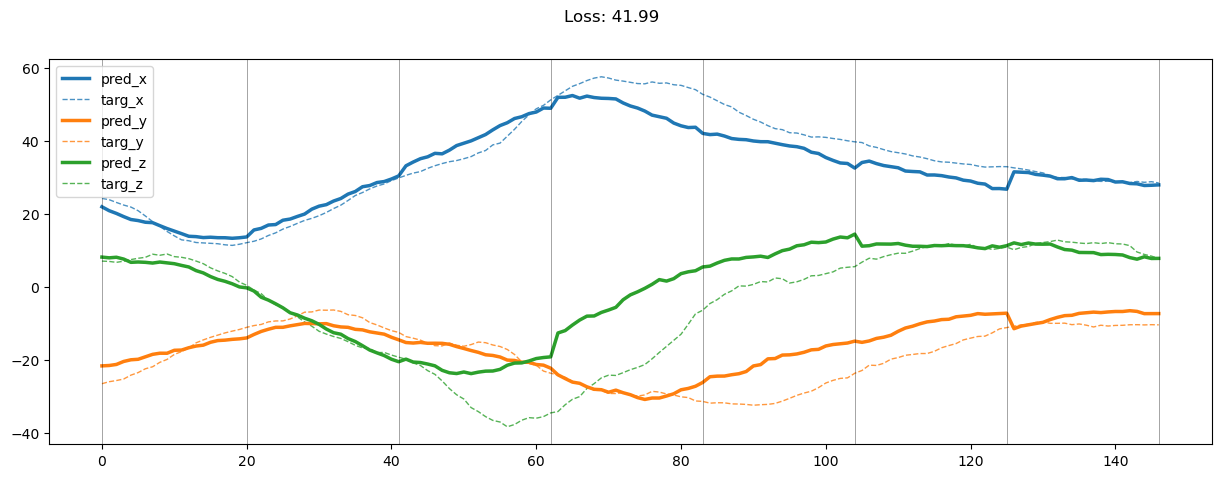

04399: train loss:  4.380, lin acc loss:  1.049, gro loss:  0.127, mag loss:  3.203
       valid loss:  41.489, lin acc loss:  0.905, gro loss:  0.129, mag loss:  40.455
04419: train loss:  4.326, lin acc loss:  0.999, gro loss:  0.125, mag loss:  3.202
       valid loss:  41.127, lin acc loss:  0.905, gro loss:  0.129, mag loss:  40.092
04439: train loss:  4.375, lin acc loss:  1.064, gro loss:  0.132, mag loss:  3.180
       valid loss:  41.648, lin acc loss:  0.905, gro loss:  0.129, mag loss:  40.615
04459: train loss:  4.556, lin acc loss:  1.068, gro loss:  0.133, mag loss:  3.355
       valid loss:  41.275, lin acc loss:  0.906, gro loss:  0.129, mag loss:  40.241
04479: train loss:  4.380, lin acc loss:  1.068, gro loss:  0.124, mag loss:  3.189
       valid loss:  40.850, lin acc loss:  0.905, gro loss:  0.129, mag loss:  39.816
04499: train loss:  4.436, lin acc loss:  1.120, gro loss:  0.129, mag loss:  3.187
       valid loss:  41.455, lin acc loss:  0.905, gro loss:  0.129

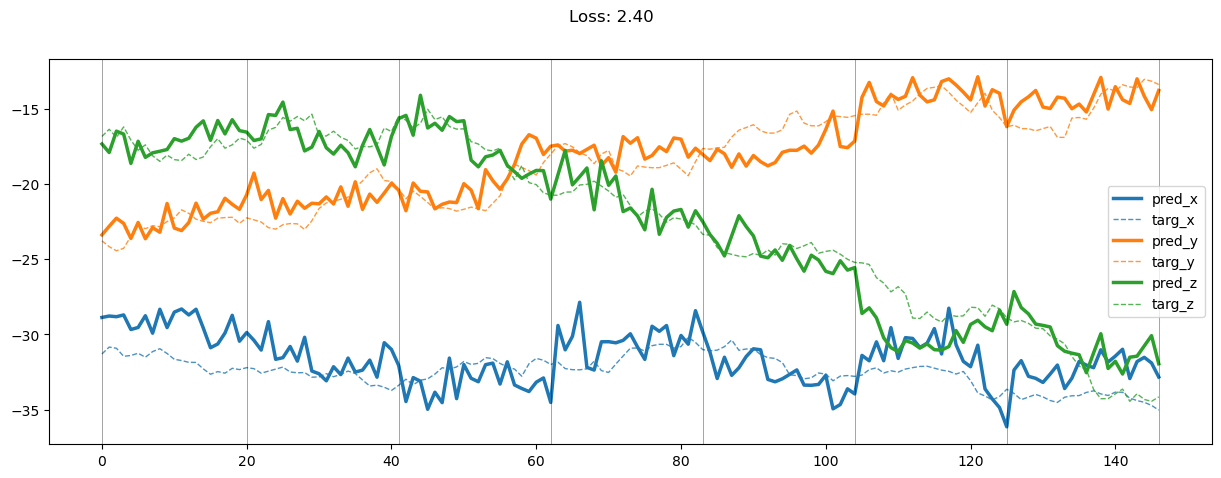

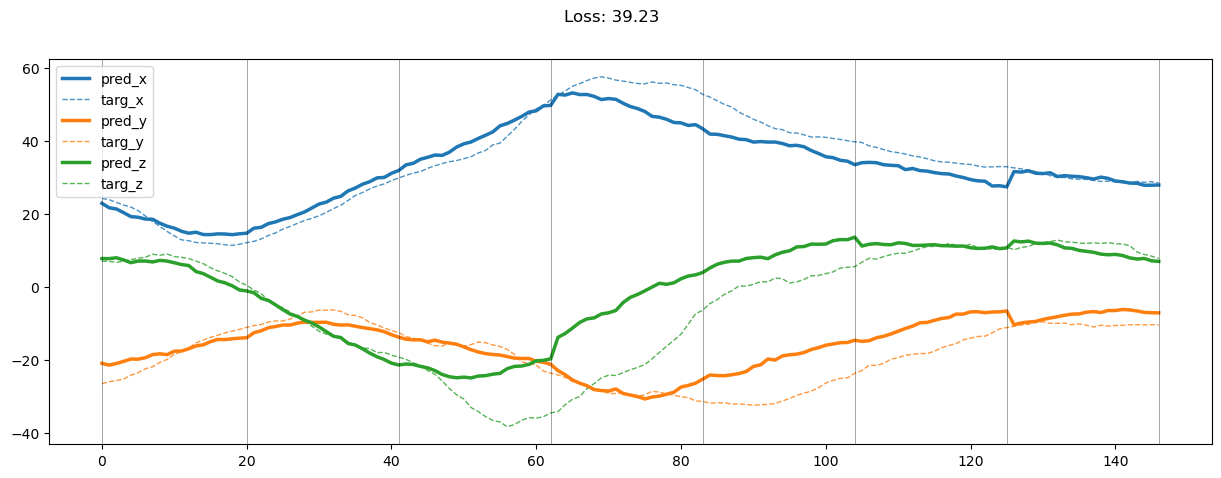

04599: train loss:  4.063, lin acc loss:  1.026, gro loss:  0.124, mag loss:  2.914
       valid loss:  42.675, lin acc loss:  0.906, gro loss:  0.128, mag loss:  41.641
04619: train loss:  4.233, lin acc loss:  1.072, gro loss:  0.125, mag loss:  3.036
       valid loss:  40.671, lin acc loss:  0.905, gro loss:  0.128, mag loss:  39.637
04639: train loss:  3.989, lin acc loss:  1.049, gro loss:  0.125, mag loss:  2.814
       valid loss:  42.808, lin acc loss:  0.905, gro loss:  0.128, mag loss:  41.775
04659: train loss:  3.954, lin acc loss:  1.055, gro loss:  0.121, mag loss:  2.778
       valid loss:  41.614, lin acc loss:  0.906, gro loss:  0.128, mag loss:  40.580
04679: train loss:  4.082, lin acc loss:  1.097, gro loss:  0.130, mag loss:  2.855
       valid loss:  40.374, lin acc loss:  0.905, gro loss:  0.128, mag loss:  39.341
04699: train loss:  4.377, lin acc loss:  0.999, gro loss:  0.121, mag loss:  3.257
       valid loss:  41.524, lin acc loss:  0.905, gro loss:  0.128

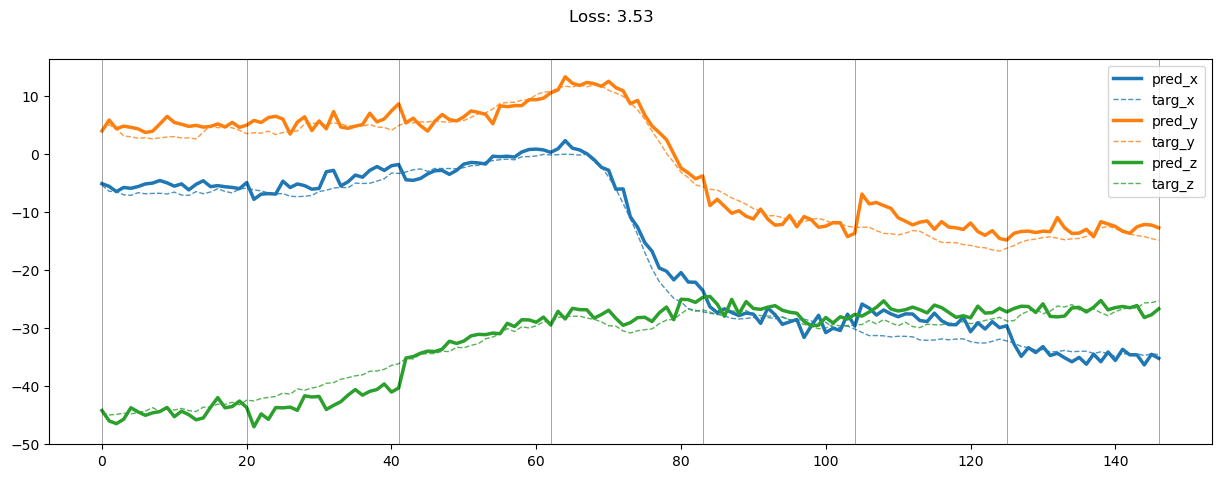

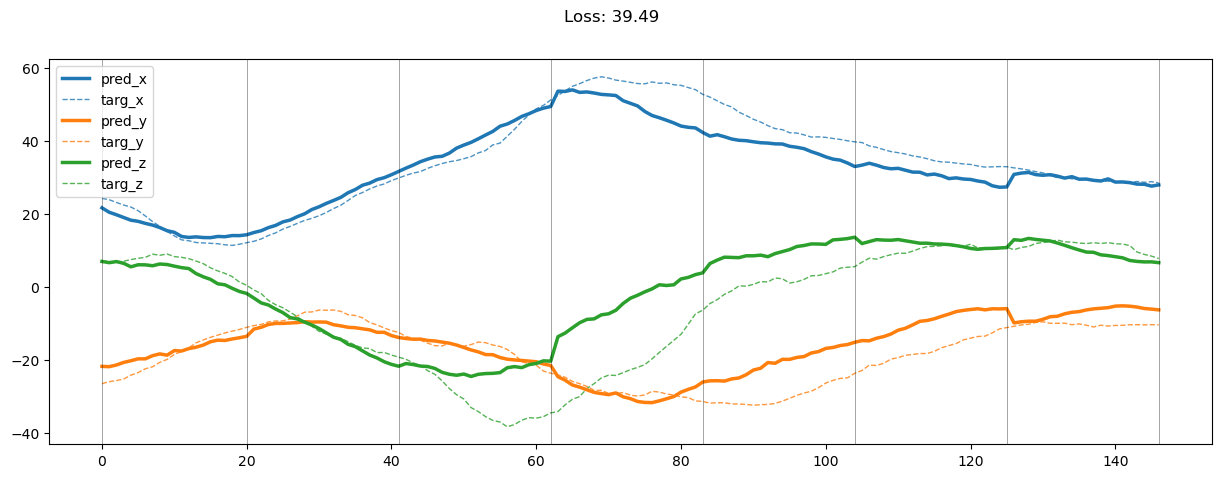

04799: train loss:  3.873, lin acc loss:  1.041, gro loss:  0.123, mag loss:  2.709
       valid loss:  42.944, lin acc loss:  0.906, gro loss:  0.128, mag loss:  41.911
04819: train loss:  3.806, lin acc loss:  1.020, gro loss:  0.128, mag loss:  2.658
       valid loss:  42.594, lin acc loss:  0.906, gro loss:  0.127, mag loss:  41.560
04839: train loss:  3.882, lin acc loss:  1.030, gro loss:  0.129, mag loss:  2.723
       valid loss:  41.358, lin acc loss:  0.906, gro loss:  0.127, mag loss:  40.325
04859: train loss:  3.692, lin acc loss:  0.992, gro loss:  0.114, mag loss:  2.586
       valid loss:  38.980, lin acc loss:  0.906, gro loss:  0.128, mag loss:  37.946
04879: train loss:  3.818, lin acc loss:  1.034, gro loss:  0.118, mag loss:  2.666
       valid loss:  41.028, lin acc loss:  0.906, gro loss:  0.128, mag loss:  39.994
04899: train loss:  3.837, lin acc loss:  1.065, gro loss:  0.121, mag loss:  2.651
       valid loss:  39.480, lin acc loss:  0.906, gro loss:  0.127

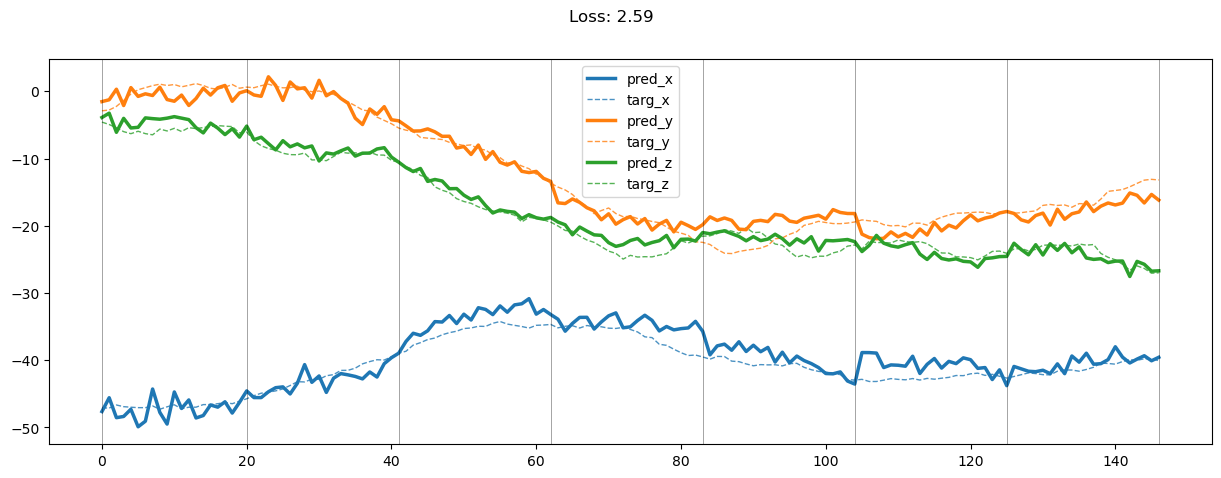

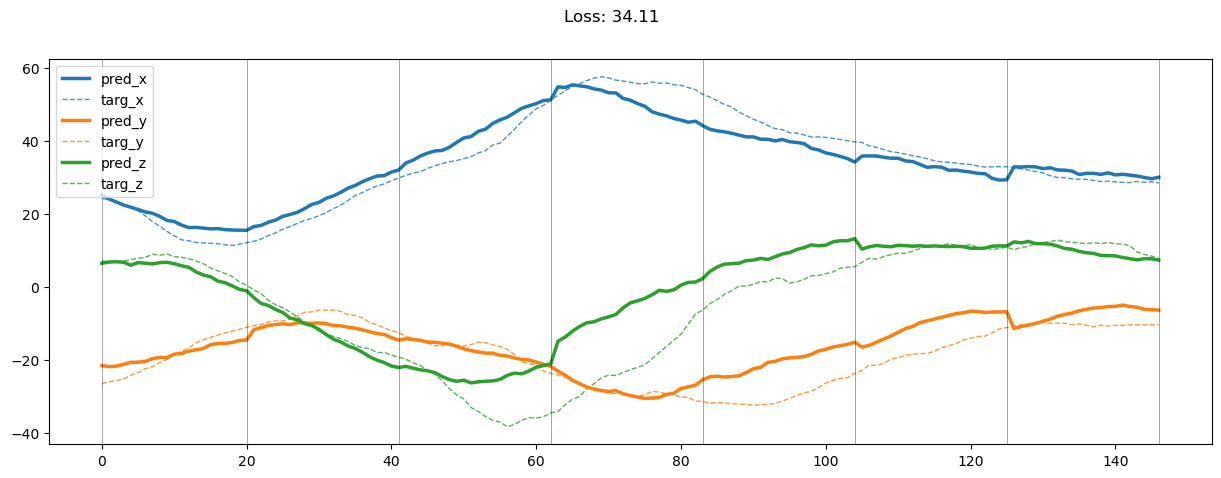

04999: train loss:  3.571, lin acc loss:  1.030, gro loss:  0.122, mag loss:  2.419
       valid loss:  40.449, lin acc loss:  0.906, gro loss:  0.127, mag loss:  39.416
05019: train loss:  3.597, lin acc loss:  1.043, gro loss:  0.123, mag loss:  2.431
       valid loss:  41.886, lin acc loss:  0.906, gro loss:  0.127, mag loss:  40.853
05039: train loss:  3.643, lin acc loss:  1.022, gro loss:  0.120, mag loss:  2.501
       valid loss:  41.274, lin acc loss:  0.906, gro loss:  0.127, mag loss:  40.241
05059: train loss:  3.781, lin acc loss:  1.017, gro loss:  0.118, mag loss:  2.645
       valid loss:  40.813, lin acc loss:  0.906, gro loss:  0.127, mag loss:  39.779
05079: train loss:  3.572, lin acc loss:  1.029, gro loss:  0.115, mag loss:  2.428
       valid loss:  44.632, lin acc loss:  0.906, gro loss:  0.127, mag loss:  43.599
05099: train loss:  3.564, lin acc loss:  1.001, gro loss:  0.114, mag loss:  2.449
       valid loss:  43.026, lin acc loss:  0.906, gro loss:  0.127

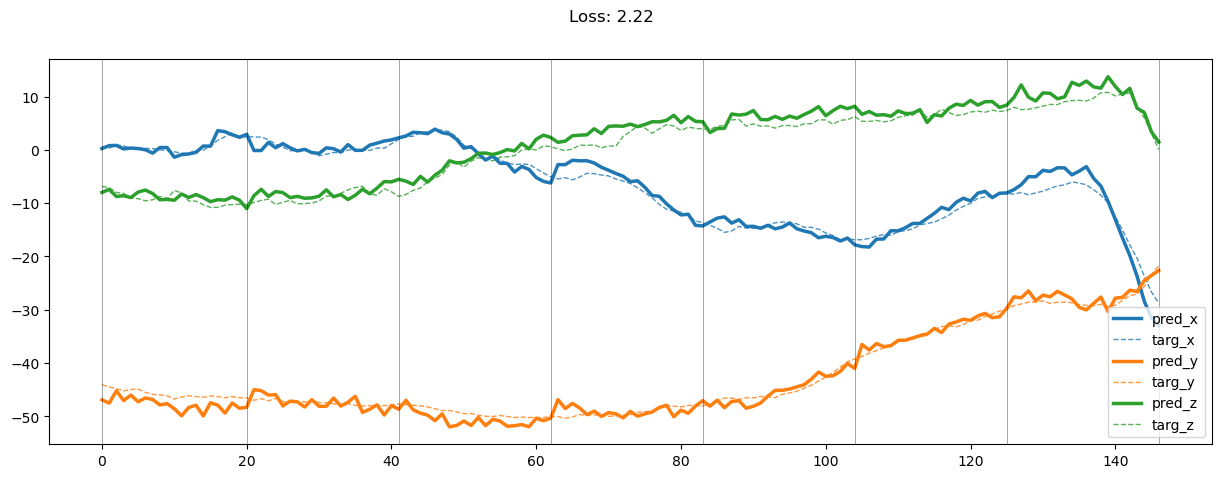

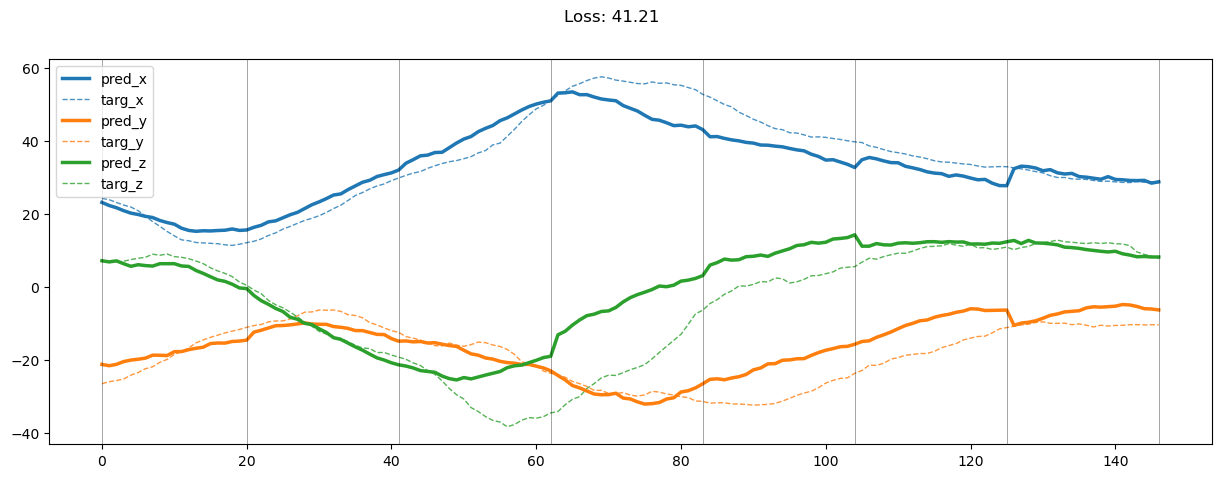

05199: train loss:  3.455, lin acc loss:  1.033, gro loss:  0.117, mag loss:  2.304
       valid loss:  40.612, lin acc loss:  0.907, gro loss:  0.126, mag loss:  39.579
05219: train loss:  3.316, lin acc loss:  1.002, gro loss:  0.117, mag loss:  2.196
       valid loss:  41.938, lin acc loss:  0.907, gro loss:  0.126, mag loss:  40.904
05239: train loss:  3.322, lin acc loss:  0.989, gro loss:  0.112, mag loss:  2.221
       valid loss:  41.764, lin acc loss:  0.907, gro loss:  0.126, mag loss:  40.731
05259: train loss:  3.496, lin acc loss:  1.033, gro loss:  0.116, mag loss:  2.348
       valid loss:  37.965, lin acc loss:  0.907, gro loss:  0.126, mag loss:  36.932
05279: train loss:  3.310, lin acc loss:  0.961, gro loss:  0.109, mag loss:  2.241
       valid loss:  40.252, lin acc loss:  0.908, gro loss:  0.126, mag loss:  39.218
05299: train loss:  3.451, lin acc loss:  0.994, gro loss:  0.113, mag loss:  2.345
       valid loss:  41.963, lin acc loss:  0.907, gro loss:  0.126

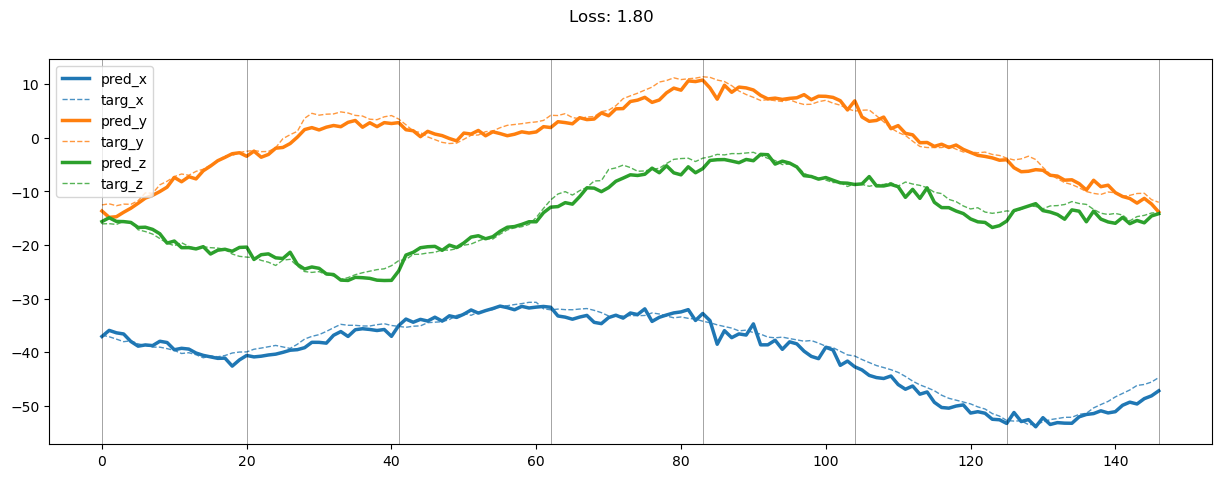

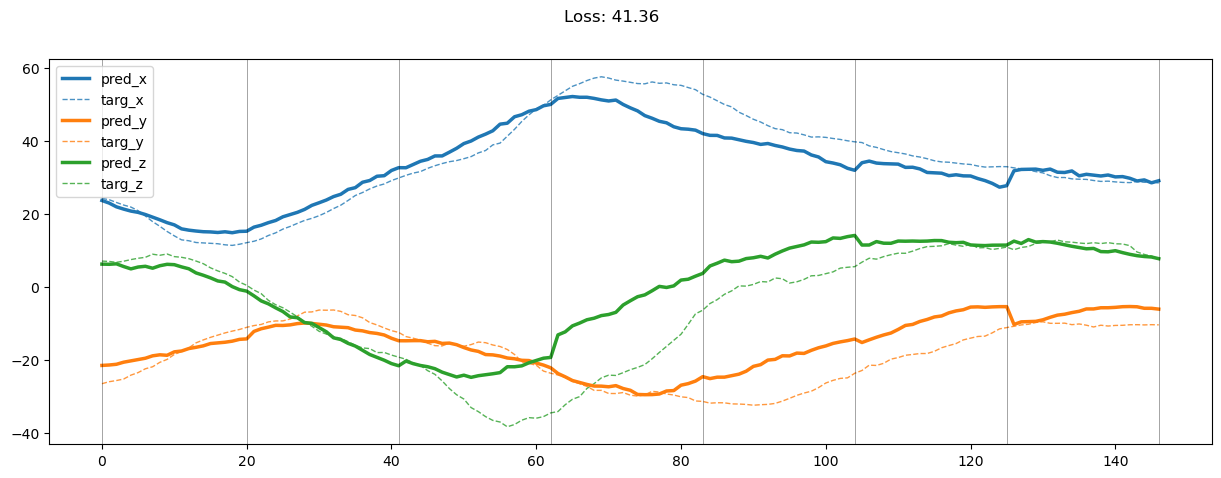

05399: train loss:  3.297, lin acc loss:  0.990, gro loss:  0.111, mag loss:  2.196
       valid loss:  40.734, lin acc loss:  0.908, gro loss:  0.126, mag loss:  39.700
05419: train loss:  3.299, lin acc loss:  1.007, gro loss:  0.119, mag loss:  2.173
       valid loss:  42.367, lin acc loss:  0.909, gro loss:  0.126, mag loss:  41.333
05439: train loss:  3.227, lin acc loss:  1.002, gro loss:  0.115, mag loss:  2.110
       valid loss:  41.982, lin acc loss:  0.909, gro loss:  0.126, mag loss:  40.948
05459: train loss:  3.224, lin acc loss:  1.004, gro loss:  0.112, mag loss:  2.108
       valid loss:  42.206, lin acc loss:  0.909, gro loss:  0.125, mag loss:  41.172
05479: train loss:  3.156, lin acc loss:  0.974, gro loss:  0.112, mag loss:  2.069
       valid loss:  42.229, lin acc loss:  0.909, gro loss:  0.125, mag loss:  41.194
05499: train loss:  3.096, lin acc loss:  0.963, gro loss:  0.108, mag loss:  2.025
       valid loss:  40.648, lin acc loss:  0.910, gro loss:  0.126

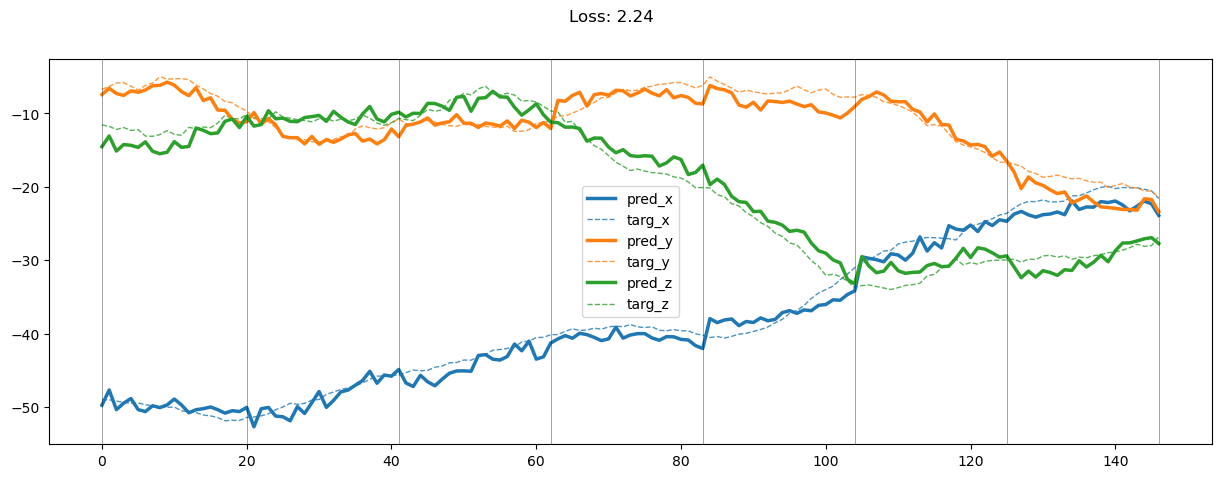

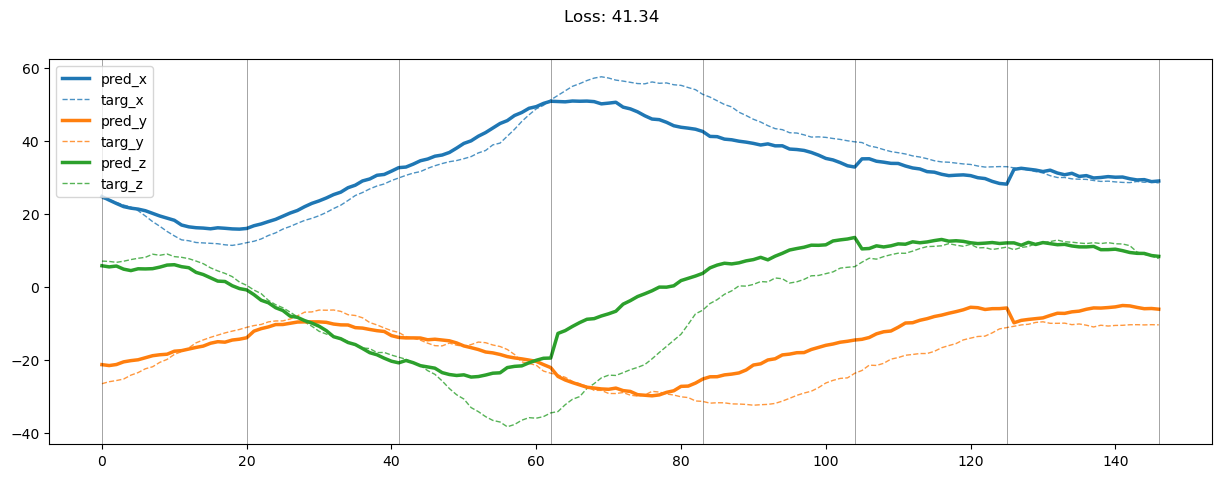

05599: train loss:  3.173, lin acc loss:  0.955, gro loss:  0.112, mag loss:  2.107
       valid loss:  41.115, lin acc loss:  0.912, gro loss:  0.125, mag loss:  40.078
05619: train loss:  3.190, lin acc loss:  1.024, gro loss:  0.118, mag loss:  2.048
       valid loss:  40.507, lin acc loss:  0.912, gro loss:  0.125, mag loss:  39.470
05639: train loss:  3.112, lin acc loss:  1.005, gro loss:  0.116, mag loss:  1.991
       valid loss:  41.835, lin acc loss:  0.911, gro loss:  0.125, mag loss:  40.799
05659: train loss:  3.087, lin acc loss:  0.999, gro loss:  0.113, mag loss:  1.975
       valid loss:  42.042, lin acc loss:  0.912, gro loss:  0.125, mag loss:  41.004
05679: train loss:  3.061, lin acc loss:  0.989, gro loss:  0.114, mag loss:  1.959
       valid loss:  42.248, lin acc loss:  0.912, gro loss:  0.125, mag loss:  41.211
05699: train loss:  3.081, lin acc loss:  0.937, gro loss:  0.106, mag loss:  2.038
       valid loss:  43.243, lin acc loss:  0.913, gro loss:  0.125

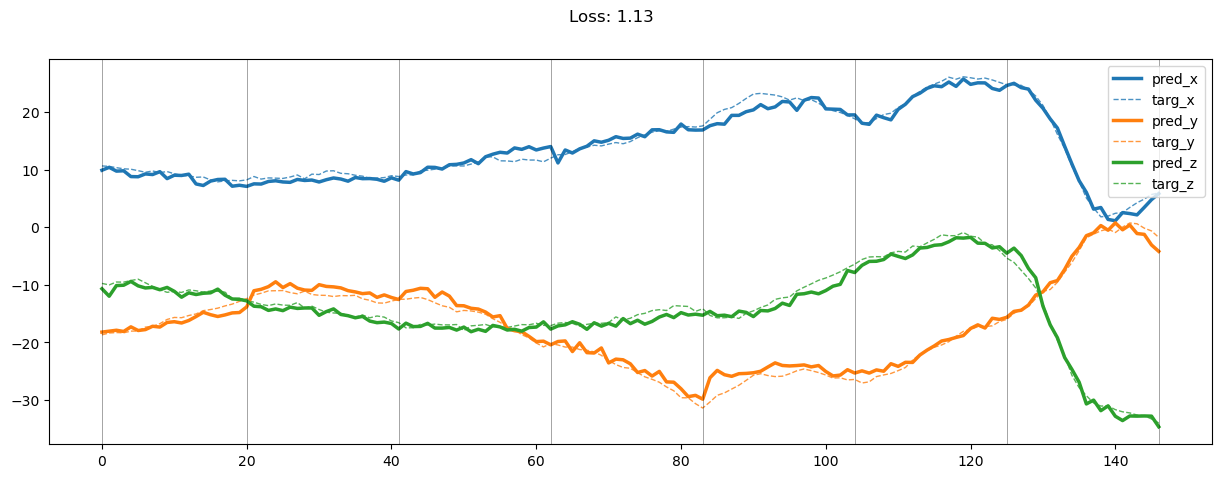

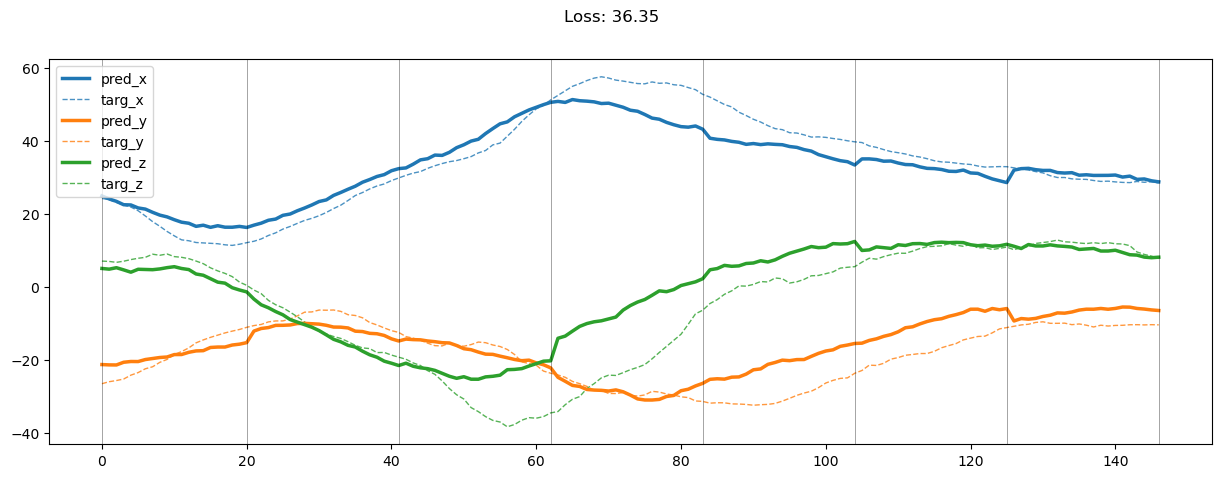

05799: train loss:  2.937, lin acc loss:  0.911, gro loss:  0.108, mag loss:  1.917
       valid loss:  40.596, lin acc loss:  0.915, gro loss:  0.125, mag loss:  39.557
05819: train loss:  2.901, lin acc loss:  0.965, gro loss:  0.104, mag loss:  1.831
       valid loss:  42.291, lin acc loss:  0.915, gro loss:  0.125, mag loss:  41.250
05839: train loss:  2.970, lin acc loss:  0.954, gro loss:  0.112, mag loss:  1.903
       valid loss:  40.868, lin acc loss:  0.915, gro loss:  0.125, mag loss:  39.828
05859: train loss:  2.883, lin acc loss:  0.951, gro loss:  0.107, mag loss:  1.825
       valid loss:  39.699, lin acc loss:  0.915, gro loss:  0.125, mag loss:  38.659
05879: train loss:  2.935, lin acc loss:  1.008, gro loss:  0.112, mag loss:  1.815
       valid loss:  41.584, lin acc loss:  0.917, gro loss:  0.125, mag loss:  40.542
05899: train loss:  2.832, lin acc loss:  0.891, gro loss:  0.107, mag loss:  1.834
       valid loss:  44.905, lin acc loss:  0.920, gro loss:  0.125

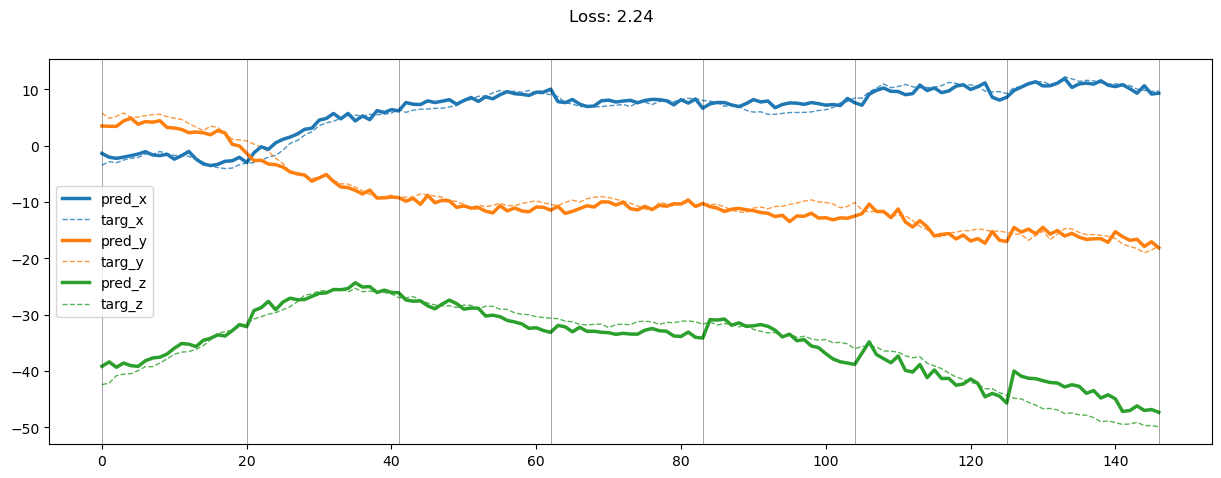

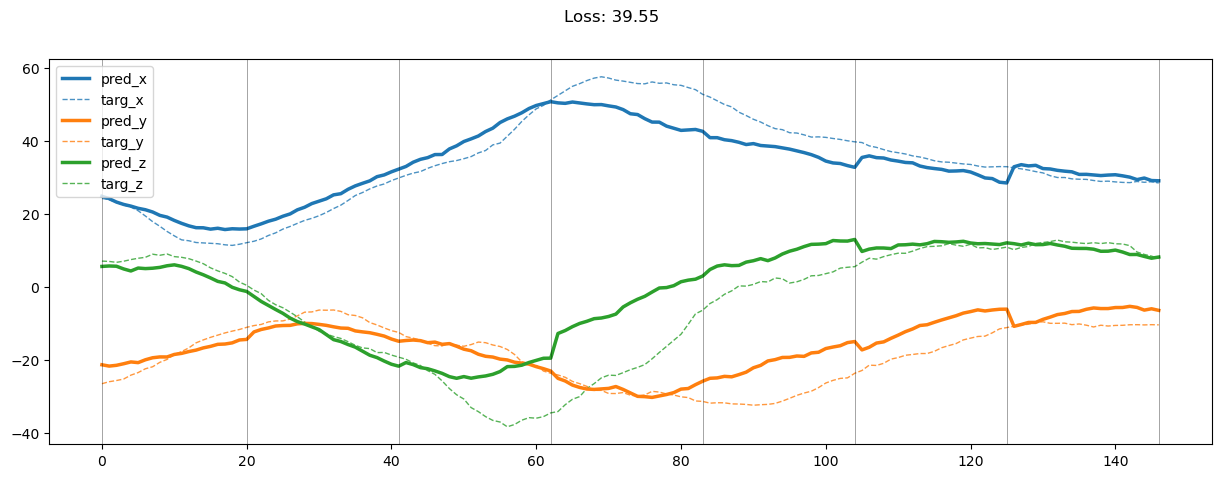

05999: train loss:  2.897, lin acc loss:  0.910, gro loss:  0.109, mag loss:  1.878
       valid loss:  41.346, lin acc loss:  0.922, gro loss:  0.124, mag loss:  40.299


In [29]:
draw = True

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 200 == 0:
        draw = True
    
    train_loss, train_lin_acc_loss, train_gro_loss, train_mag_loss = train(train_loader, draw)
    valid_loss, valid_lin_acc_loss, valid_gro_loss, valid_mag_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 20 == 0:
        ep = str(epoch).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, lin acc loss: {train_lin_acc_loss: 2.3f}, gro loss: {train_gro_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, lin acc loss: {valid_lin_acc_loss: 2.3f}, gro loss: {valid_gro_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}')

In [30]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data[:, :, :, 0:9].to(device)
            target_data = target_data[:, :, :, 0:9].to(device)

            # generate mag
            predict_data = model(source_data)

            # generator loss
            gen_loss, lin_acc_loss, gro_loss, mag_loss = generator_loss(predict_data, target_data)

            results.extend(zip(predict_data[:, :, :, 6:9].detach().cpu().numpy(), target_data[:, :, :, 6:9].cpu().numpy()))
    
    return np.array(results)

In [31]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

(310, 2, 7, 21, 3)


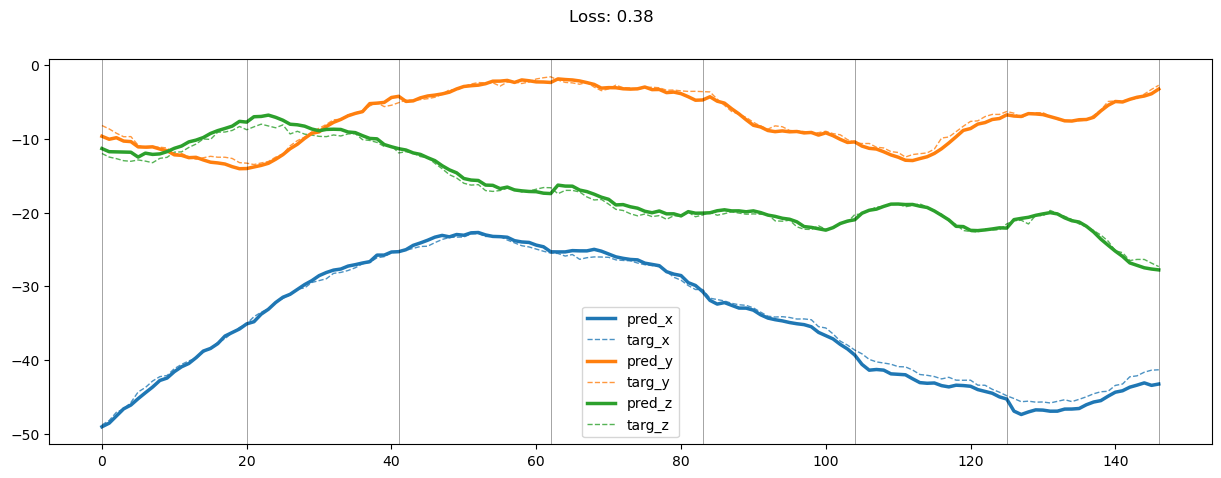

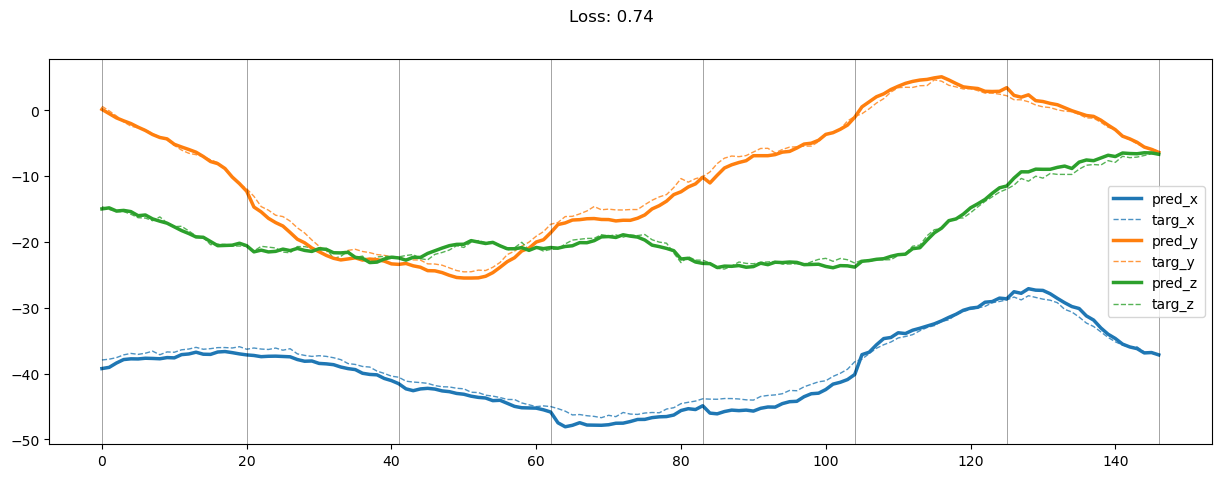

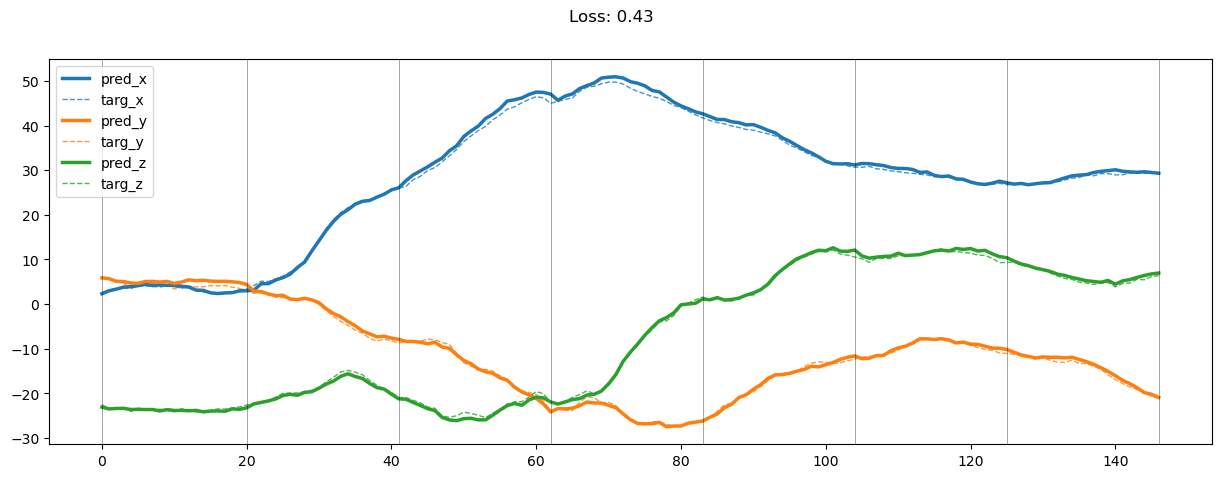

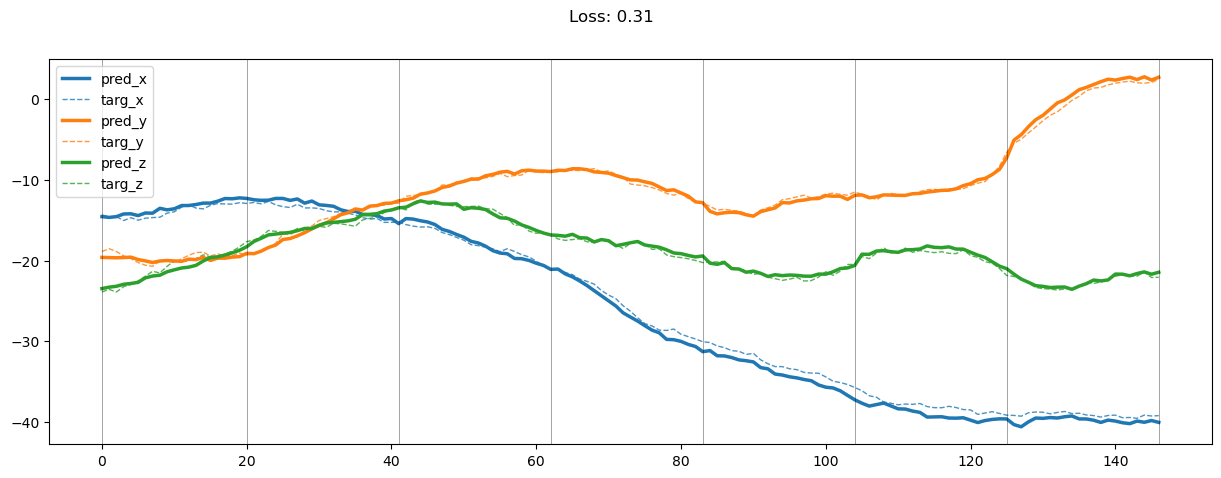

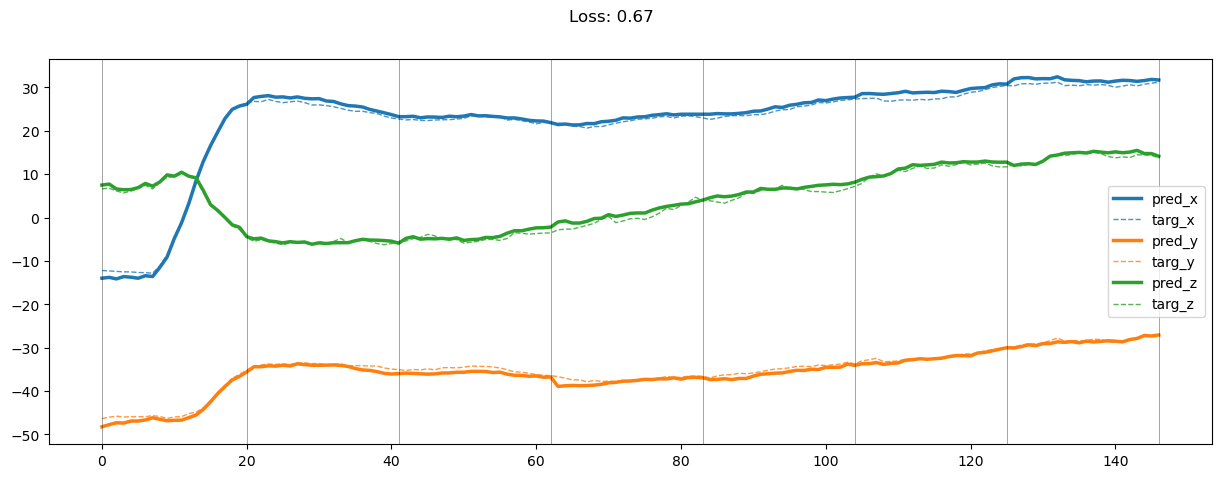

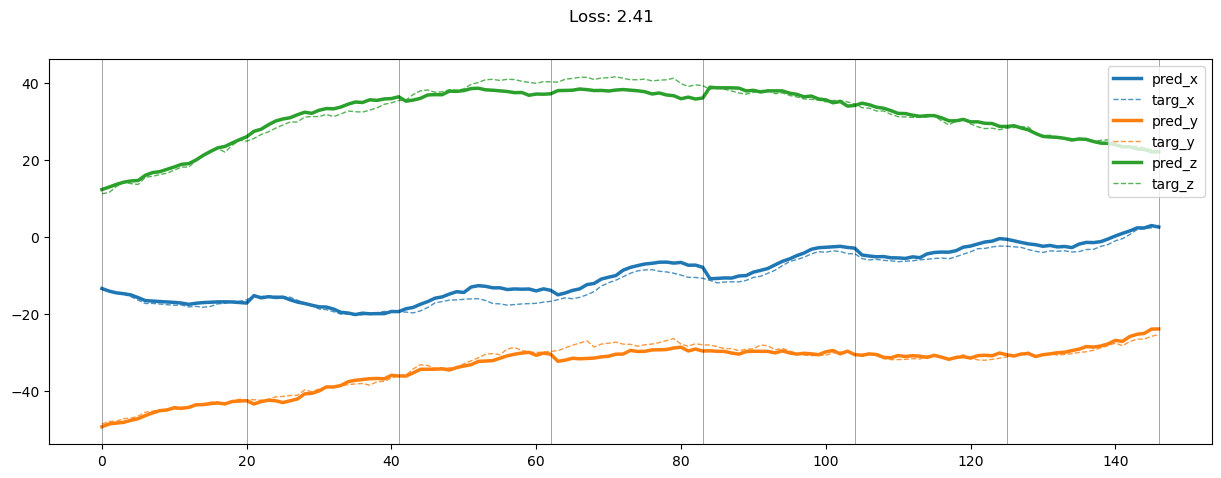

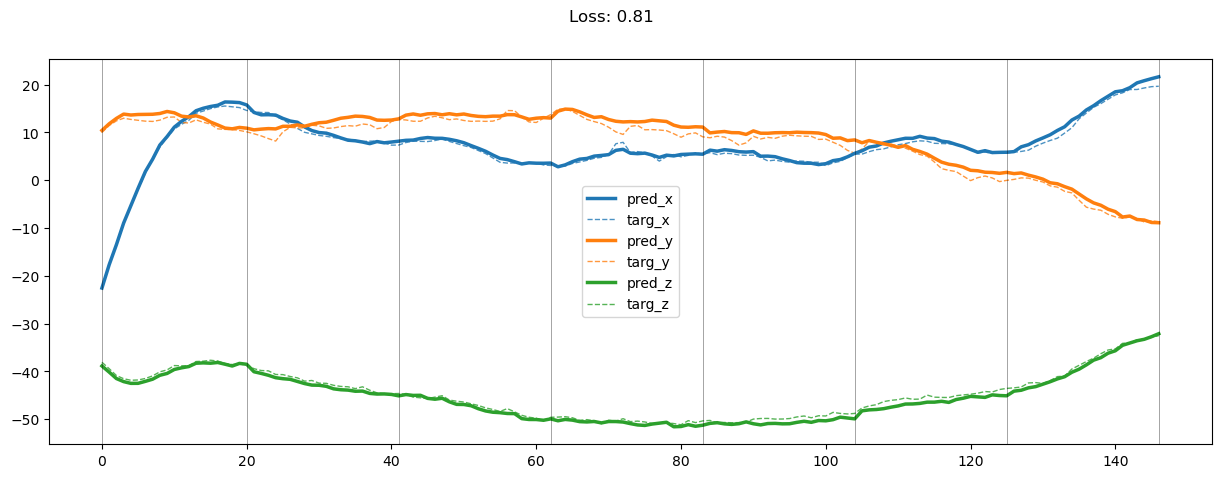

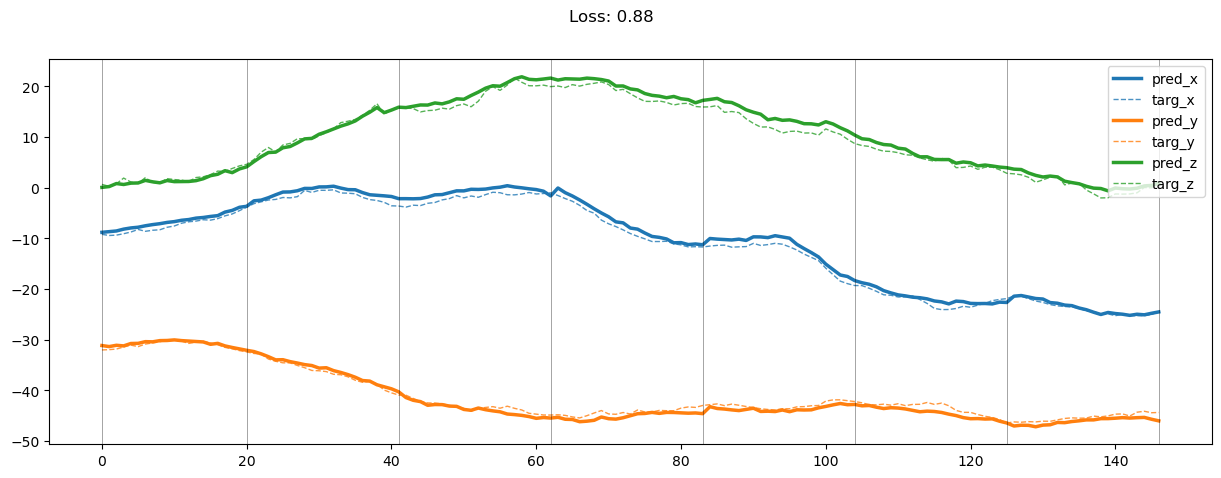

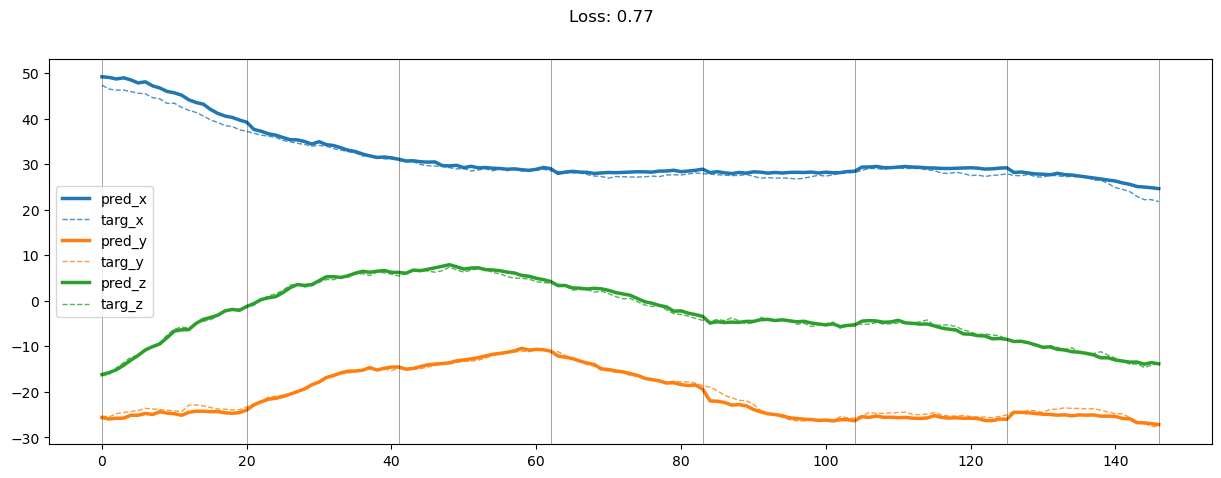

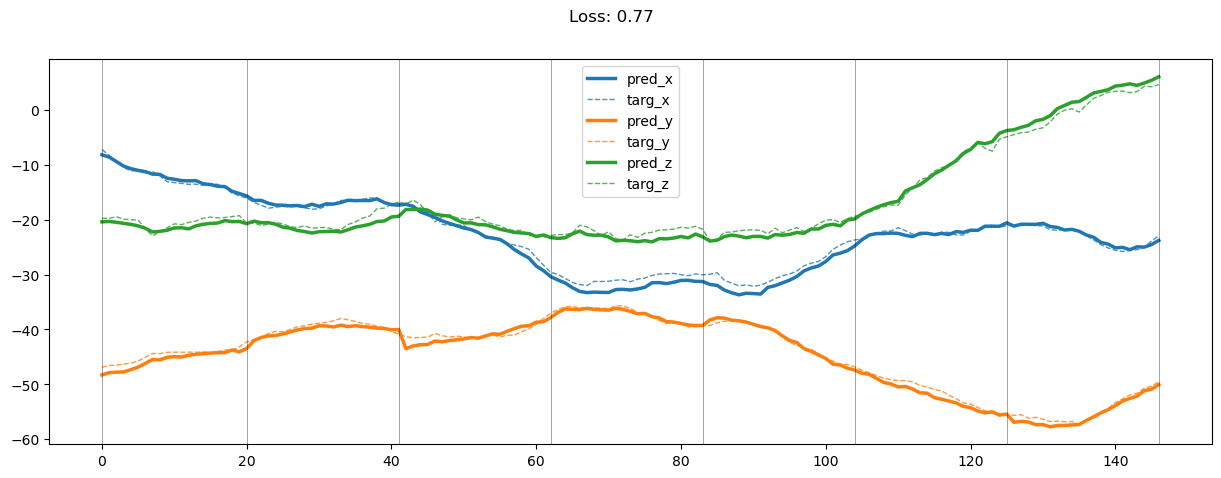

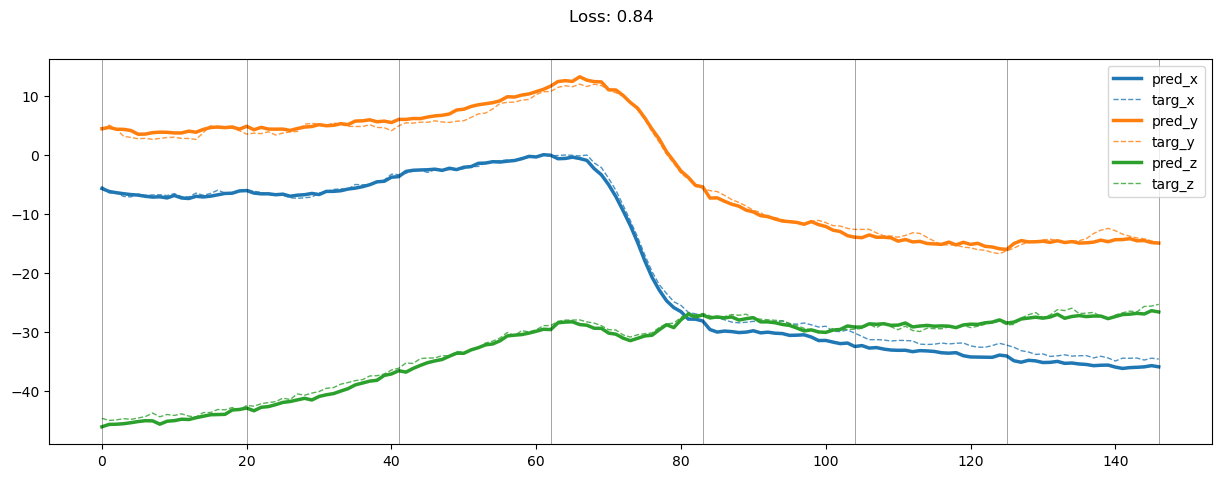

In [32]:
results = output_eval(model, train_loader)

print(results.shape)

for rs in results[::30]:
    plot_result(rs)

(78, 2, 7, 21, 3)


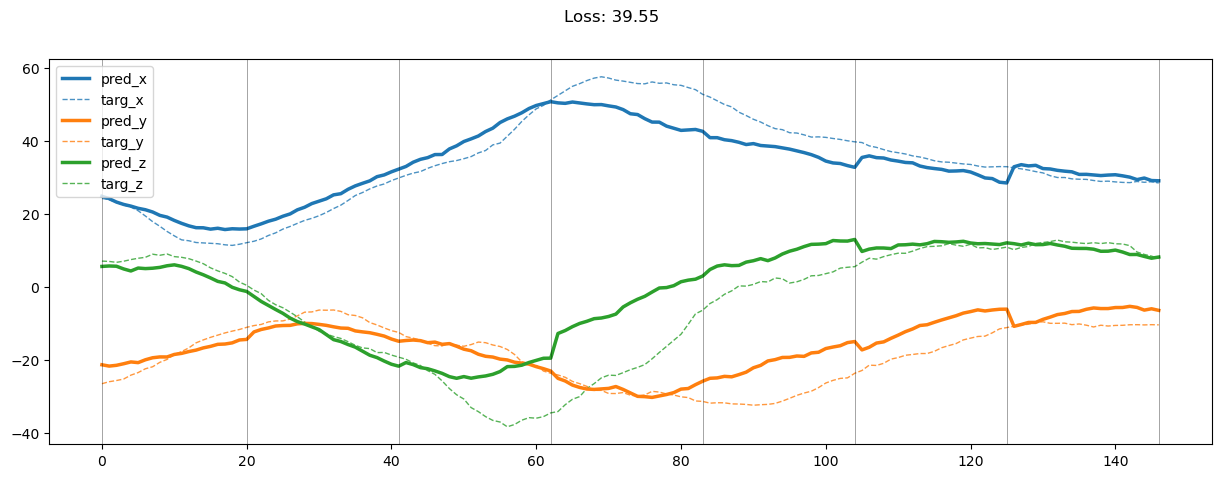

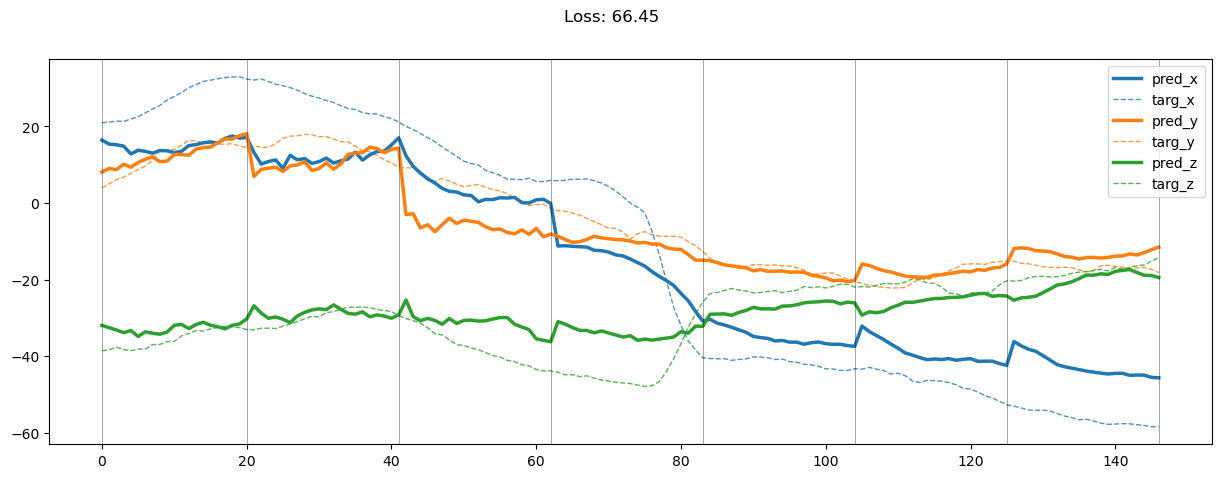

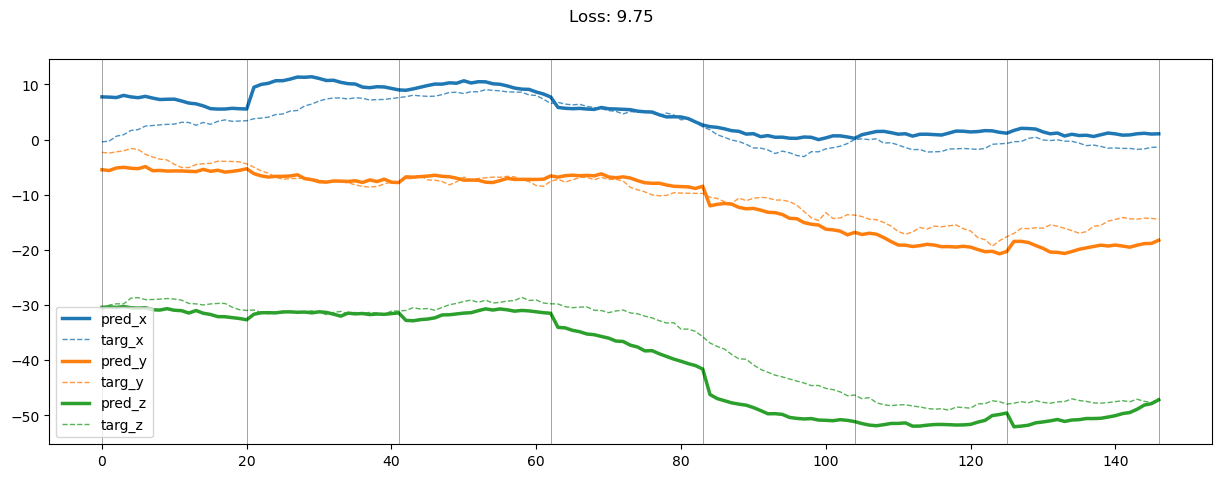

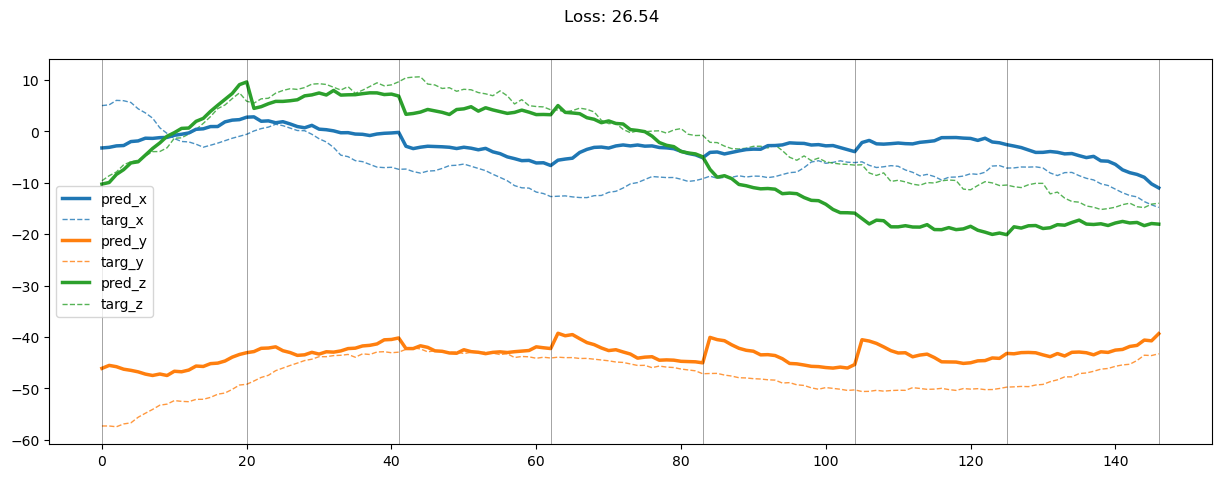

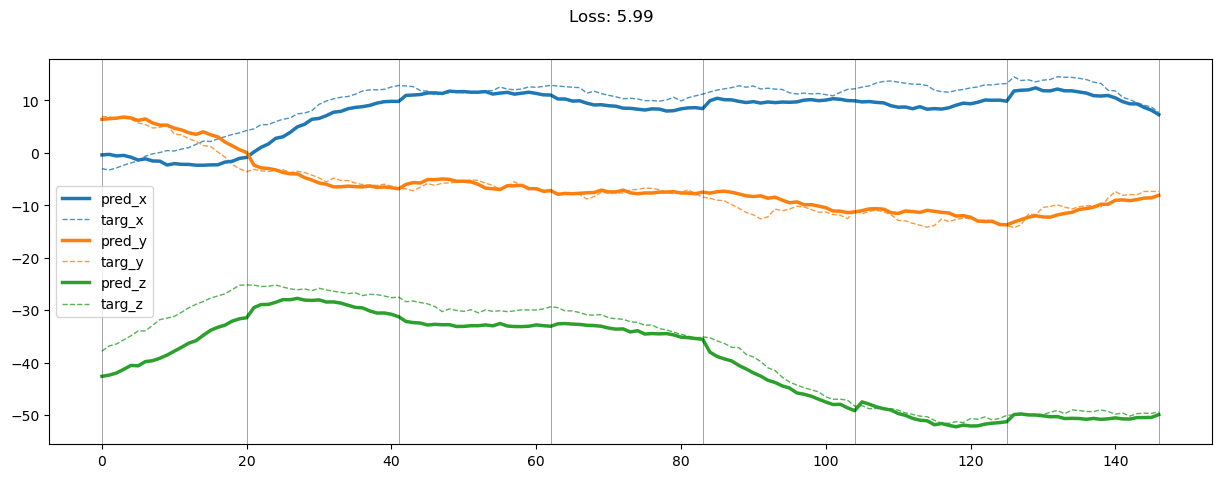

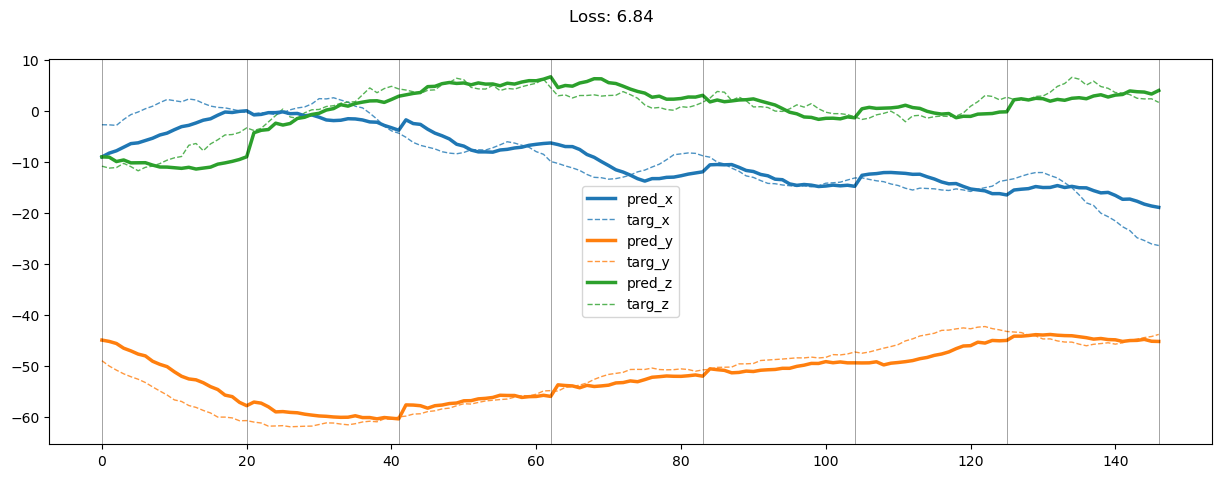

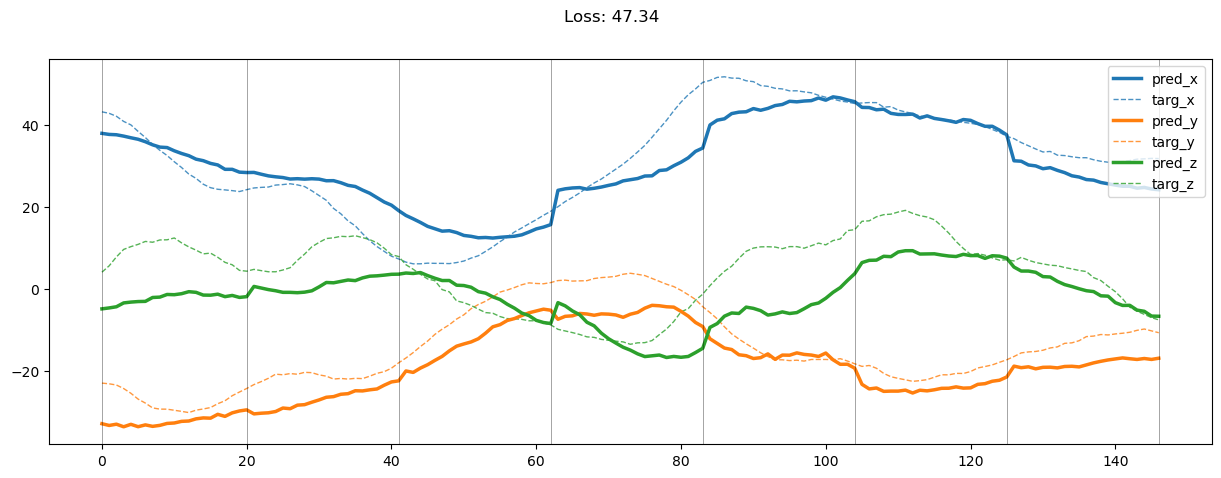

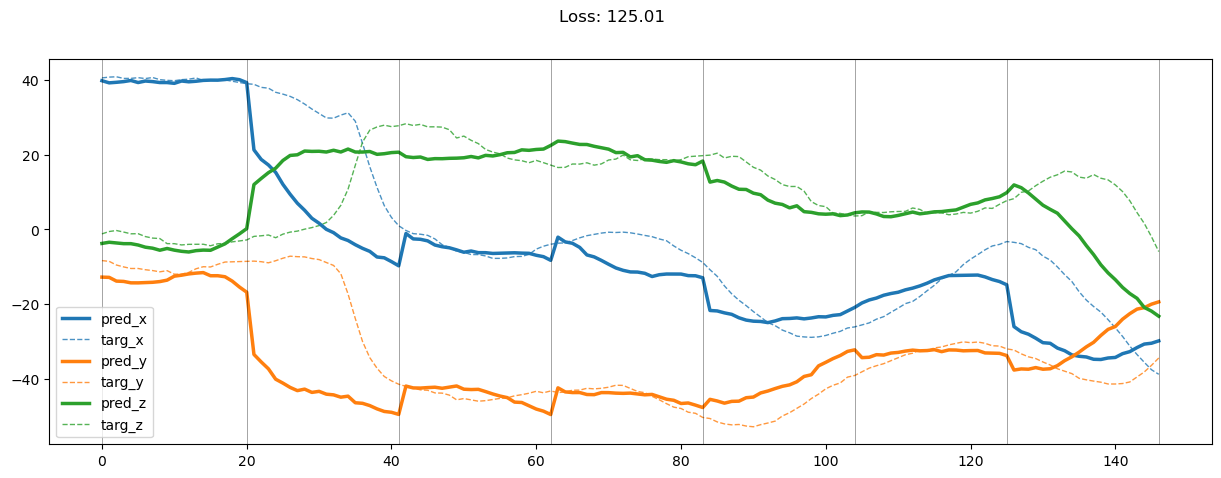

In [33]:
results = output_eval(model, valid_loader)

print(results.shape)

for rs in results[::10]:
    plot_result(rs)